In [74]:
from pandas.core.common import random_state
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
import os
import numpy as np
from Classification.cnn1D_model_with_freq import VibrationDataset, CNN1D_DS, FrequencyDomainCNN
from Classification.cnn1D_model_with_freq import train_and_evaluate
import torch
from torch.utils.data import Dataset, DataLoader, random_split,Subset
from sklearn.model_selection import train_test_split
import random
import pandas as pd
from utils.baseline_xai import predict_single, summarize_attributions
from utils.baseline_xai import grad_times_input_relevance, smoothgrad_relevance, occlusion_signal_relevance, occlusion_simpler_relevance
from  visualization.relevance_visualization import visualize_with_label_attribution, visualize_lrp_single_sample, visualize_lrp_dft, visualize_lrp_fft, visualize_crp_heatmap
from utils.xai_implementation import compute_lrp_relevance, compute_dft_lrp_relevance, compute_fft_lrp_relevance
from sklearn.model_selection import GroupKFold
from collections import Counter
from utils.crp_utils import *

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# Load dataset, Stratify based on Lable and Operation, so that the train, test, val sets have appropriate amount of each group

data_directory = "../data/final/new_selection/normalized_windowed_downsampled_data"
dataset = VibrationDataset(data_directory, augment_bad=False)

# Create a combined stratification key (label_operation)
stratify_key = [f"{lbl}_{op}" for lbl, op in zip(dataset.labels, dataset.operations)]

# Stratified split by both label and operation
train_idx, temp_idx = train_test_split(
    range(len(dataset)), test_size=0.3, stratify=stratify_key
)
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, stratify=[stratify_key[i] for i in temp_idx]
)

# Create Subset datasets
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

# Verify split sizes and label distribution
print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")
print(f"Train good: {sum(dataset.labels[train_idx] == 0)}, Train bad: {sum(dataset.labels[train_idx] == 1)}")
print(f"Val good: {sum(dataset.labels[val_idx] == 0)}, Val bad: {sum(dataset.labels[val_idx] == 1)}")
print(f"Test good: {sum(dataset.labels[test_idx] == 0)}, Test bad: {sum(dataset.labels[test_idx] == 1)}")

# Class ratios
train_ratio = sum(dataset.labels[train_idx] == 0) / sum(dataset.labels[train_idx] == 1)
val_ratio = sum(dataset.labels[val_idx] == 0) / sum(dataset.labels[val_idx] == 1)
test_ratio = sum(dataset.labels[test_idx] == 0) / sum(dataset.labels[test_idx] == 1)
print(f"Class ratio (good/bad) - Train: {train_ratio:.2f}, Val: {val_ratio:.2f}, Test: {test_ratio:.2f}")

# Operation distribution
train_ops = Counter(dataset.operations[train_idx])
val_ops = Counter(dataset.operations[val_idx])
test_ops = Counter(dataset.operations[test_idx])
print(f"Train operations: {train_ops}")
print(f"Val operations: {val_ops}")
print(f"Test operations: {test_ops}")

# Creating DataLoaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Train size: 5250, Val size: 1125, Test size: 1126
Train good: 3924, Train bad: 1326
Val good: 839, Val bad: 286
Test good: 843, Test bad: 283
Class ratio (good/bad) - Train: 2.96, Val: 2.93, Test: 2.98
Train operations: Counter({np.str_('OP06'): 806, np.str_('OP04'): 694, np.str_('OP10'): 568, np.str_('OP12'): 559, np.str_('OP02'): 551, np.str_('OP11'): 534, np.str_('OP08'): 442, np.str_('OP14'): 330, np.str_('OP01'): 321, np.str_('OP07'): 279, np.str_('OP05'): 166})
Val operations: Counter({np.str_('OP06'): 173, np.str_('OP04'): 148, np.str_('OP10'): 121, np.str_('OP12'): 120, np.str_('OP02'): 119, np.str_('OP11'): 114, np.str_('OP08'): 94, np.str_('OP14'): 71, np.str_('OP01'): 69, np.str_('OP07'): 60, np.str_('OP05'): 36})
Test operations: Counter({np.str_('OP06'): 173, np.str_('OP04'): 149, np.str_('OP10'): 122, np.str_('OP12'): 119, np.str_('OP02'): 118, np.str_('OP11'): 115, np.str_('OP08'): 95, np.str_('OP14'): 71, np.str_('OP01'): 69, np.str_('OP07'): 60, np.str_('OP05'): 35})


Using device: cuda
Epoch [1/20] - Train Loss: 0.4311, Train Acc: 0.8070 - Val Loss: 0.1897, Val Acc: 0.9458 
Epoch [2/20] - Train Loss: 0.1136, Train Acc: 0.9728 - Val Loss: 0.0397, Val Acc: 0.9929 
Epoch [3/20] - Train Loss: 0.0418, Train Acc: 0.9909 - Val Loss: 0.0407, Val Acc: 0.9849 
Epoch [4/20] - Train Loss: 0.0276, Train Acc: 0.9922 - Val Loss: 0.0077, Val Acc: 0.9982 
Epoch [5/20] - Train Loss: 0.0291, Train Acc: 0.9914 - Val Loss: 0.0080, Val Acc: 0.9982 
Epoch [6/20] - Train Loss: 0.0296, Train Acc: 0.9920 - Val Loss: 0.0132, Val Acc: 0.9956 
Epoch [7/20] - Train Loss: 0.0178, Train Acc: 0.9958 - Val Loss: 0.0039, Val Acc: 1.0000 
Epoch [8/20] - Train Loss: 0.0167, Train Acc: 0.9956 - Val Loss: 0.0222, Val Acc: 0.9893 
Epoch [9/20] - Train Loss: 0.0231, Train Acc: 0.9924 - Val Loss: 0.0032, Val Acc: 0.9991 
Epoch [10/20] - Train Loss: 0.0149, Train Acc: 0.9960 - Val Loss: 0.0029, Val Acc: 0.9991 
Epoch [11/20] - Train Loss: 0.0176, Train Acc: 0.9947 - Val Loss: 0.0024, Val Ac

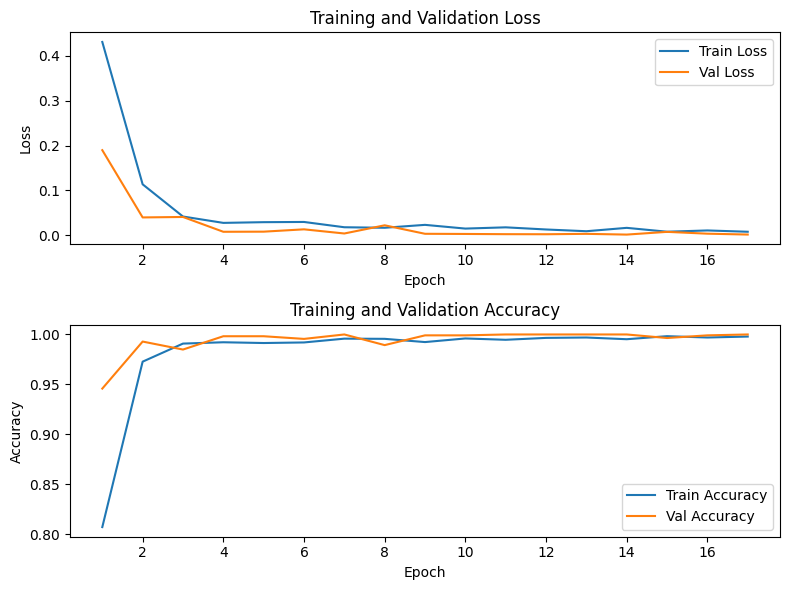

In [6]:
freq_model = train_and_evaluate(train_loader, val_loader, test_loader, EralyStopping=True)


In [7]:
# Save the trained model
torch.save(freq_model.state_dict(), "../cnn1d_freq.ckpt")
print("✅ Model saved to cnn1d_freq.ckpt")
freq_model.to(device)
freq_model.eval()  # Switch to evaluation mode
print("✅ Model loaded and ready for explanations")
print(f"✅ Model is structured as  \n {freq_model}")


✅ Model saved to cnn1d_freq.ckpt
✅ Model loaded and ready for explanations
✅ Model is structured as  
 FrequencyDomainCNN(
  (time_cnn): CNN1D_DS(
    (feature_extractor): Sequential(
      (0): Conv1d(3, 16, kernel_size=(9,), stride=(1,))
      (1): GroupNorm(4, 16, eps=1e-05, affine=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv1d(16, 32, kernel_size=(7,), stride=(1,))
      (5): GroupNorm(4, 32, eps=1e-05, affine=True)
      (6): ReLU()
      (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv1d(32, 64, kernel_size=(5,), stride=(1,))
      (9): GroupNorm(4, 64, eps=1e-05, affine=True)
      (10): ReLU()
      (11): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (12): AdaptiveAvgPool1d(output_size=1)
    )
    (classifier): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Drop

### Explain the Model

#### choose a good sample

In [72]:
# Load a Good sample

# Load a batch
sample_batch, label_batch = next(iter(test_loader))
print(len(sample_batch), len(label_batch))

# Choose a random index
random.seed(42)
random_index = random.randint(0, len(sample_batch) - 1)


# Select the random sample and its corresponding label
sample = sample_batch[random_index]  # Shape: (3, 10000)
label = label_batch[random_index]    # Shape: ()



sample = sample.to(device)
label = label.to(device)

_, predicted_label = predict_single(freq_model, sample)


# Print the selected sample and label
print(f"Random Index: {random_index}, Predicted_label:{predicted_label}, True_label:{label}")
print(sample, sample.shape)


128 128
Random Index: 28, Predicted_label:0, True_label:0
tensor([[-0.0202,  0.0294, -0.0223,  ..., -0.0380, -0.0145,  0.0232],
        [ 0.2119, -0.1976,  0.1761,  ..., -0.7802,  0.6041, -0.7537],
        [-0.1483,  0.1933, -0.1660,  ...,  0.0337, -0.0053,  0.0846]],
       device='cuda:0') torch.Size([3, 2000])


#### DFT-LRP implementation

In [9]:
relevance_time, relevance_freq, signal_freq, input_signal, freqs, predicted_label = compute_dft_lrp_relevance(
        model=freq_model,
        sample=sample.cpu().detach().numpy(),  # Convert to NumPy for DFTLRP
        label=label.item(),
        device=device,
        signal_length=2000,   #10000 if we did not downsample
        sampling_rate=400  # Placeholder, replace with your actual sampling rate     #2000 if we did not downsample
    )

Input device in zennit_relevance: cuda:0
Input device in zennit_relevance_lrp: cuda:0
Input sample shape: torch.Size([1, 3, 2000])
Relevance time shape: (3, 2000)
Input signal shape: (3, 2000)
Weight shape in create_fourier_weights: (2000, 2000)
Raw weight shape from dft_utils: (2000, 2000)
Weight shape after tensor conversion: torch.Size([2000, 2000])
Weight shape in create_fourier_weights: (2000, 2000)
Raw weight shape from dft_utils: (2000, 2000)
Weight shape after tensor conversion: torch.Size([2000, 2000])
Number of axis is: 3
Frequency length is:1001
Input signal shape: (1, 2000)
Input relevance shape: (1, 2000)
Signal hat shape after transform: torch.Size([1, 2000])
Relevance hat shape before multiplication: torch.Size([1, 2000])
Relevance hat shape after multiplication: torch.Size([1, 2000])
Input signal shape: (1, 2000)
Input relevance shape: (1, 2000)
Signal hat shape after transform: torch.Size([1, 2000])
Relevance hat shape before multiplication: torch.Size([1, 2000])
Relev

E:\Thesis\Datasets\CNC\utils\dft_lrp.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input, dtype=dtype)


Min relevance: -0.046189967542886734, Max relevance: 0.036051973700523376
 Maximum Absolute Attribution in Axis 0: 0.021147718653082848
 Maximum Absolute Attribution in Axis 1: 0.036051973700523376
 Maximum Absolute Attribution in Axis 2: 0.046189967542886734


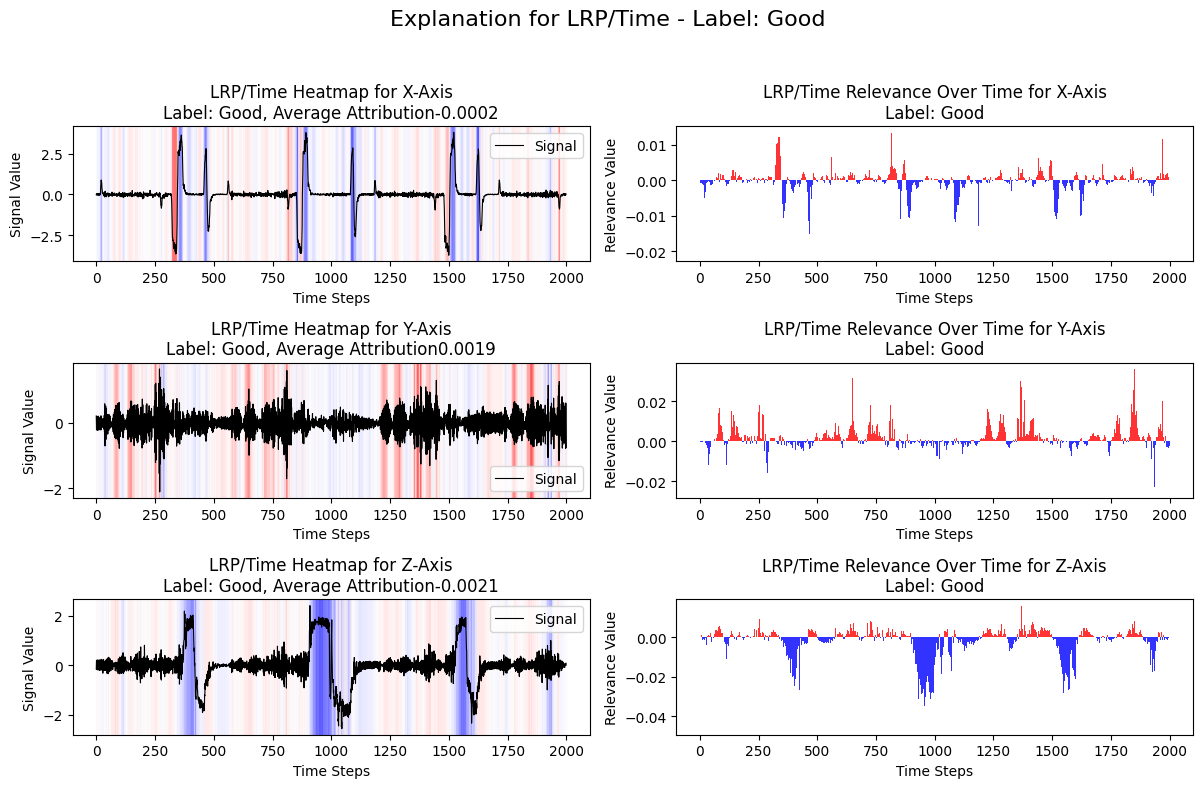

In [10]:
# LRP visualization with mutual visualization function
print(f"Min relevance: {np.min(relevance_time)}, Max relevance: {np.max(relevance_time)}")
visualize_with_label_attribution(sample, relevance_time, label, "LRP/Time")


In [11]:
""# Global Attribution over frequency with LRP
summary_lrp_freq = summarize_attributions(relevance_freq)  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_lrp_freq = []
for axis, values in summary_lrp_freq.items():
    row = {"Axis": axis}
    row.update(values)
    data_lrp_freq.append(row)

# Create the DataFrame
df_summary_lrp_freq = pd.DataFrame(data_lrp_freq)

# Display the DataFrame as a table
print(df_summary_lrp_freq)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0             508                 73.936548   
1  Axis 1             485                 10.040391   
2  Axis 2             496                 36.687105   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.145544             493                -74.359607   
1                    0.020702             516                 -6.190158   
2                    0.073966             505                -40.736601   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.150831                    -0.423059   
1                   -0.011996                     3.850233   
2                   -0.080667                    -4.049496   

   Average Relevance (Pos + Neg)  
0                      -0.000423  
1                       0.003846  
2                      -0.004045  


In [12]:
""# Global Attribution over frequency with LRP
summary_lrp_t = summarize_attributions(relevance_time)  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_lrp_t = []
for axis, values in summary_lrp_t.items():
    row = {"Axis": axis}
    row.update(values)
    data_lrp_t.append(row)

# Create the DataFrame
df_summary_lrp_t = pd.DataFrame(data_lrp_t)

# Display the DataFrame as a table
print(df_summary_lrp_t)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0            1027                  1.532312   
1  Axis 1            1207                  5.453089   
2  Axis 2            1014                  2.297824   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.001492             973                 -1.960022   
1                    0.004518             793                 -1.596478   
2                    0.002266             986                 -6.439903   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.002014                    -0.427710   
1                   -0.002013                     3.856612   
2                   -0.006531                    -4.142079   

   Average Relevance (Pos + Neg)  
0                      -0.000214  
1                       0.001928  
2                      -0.002071  


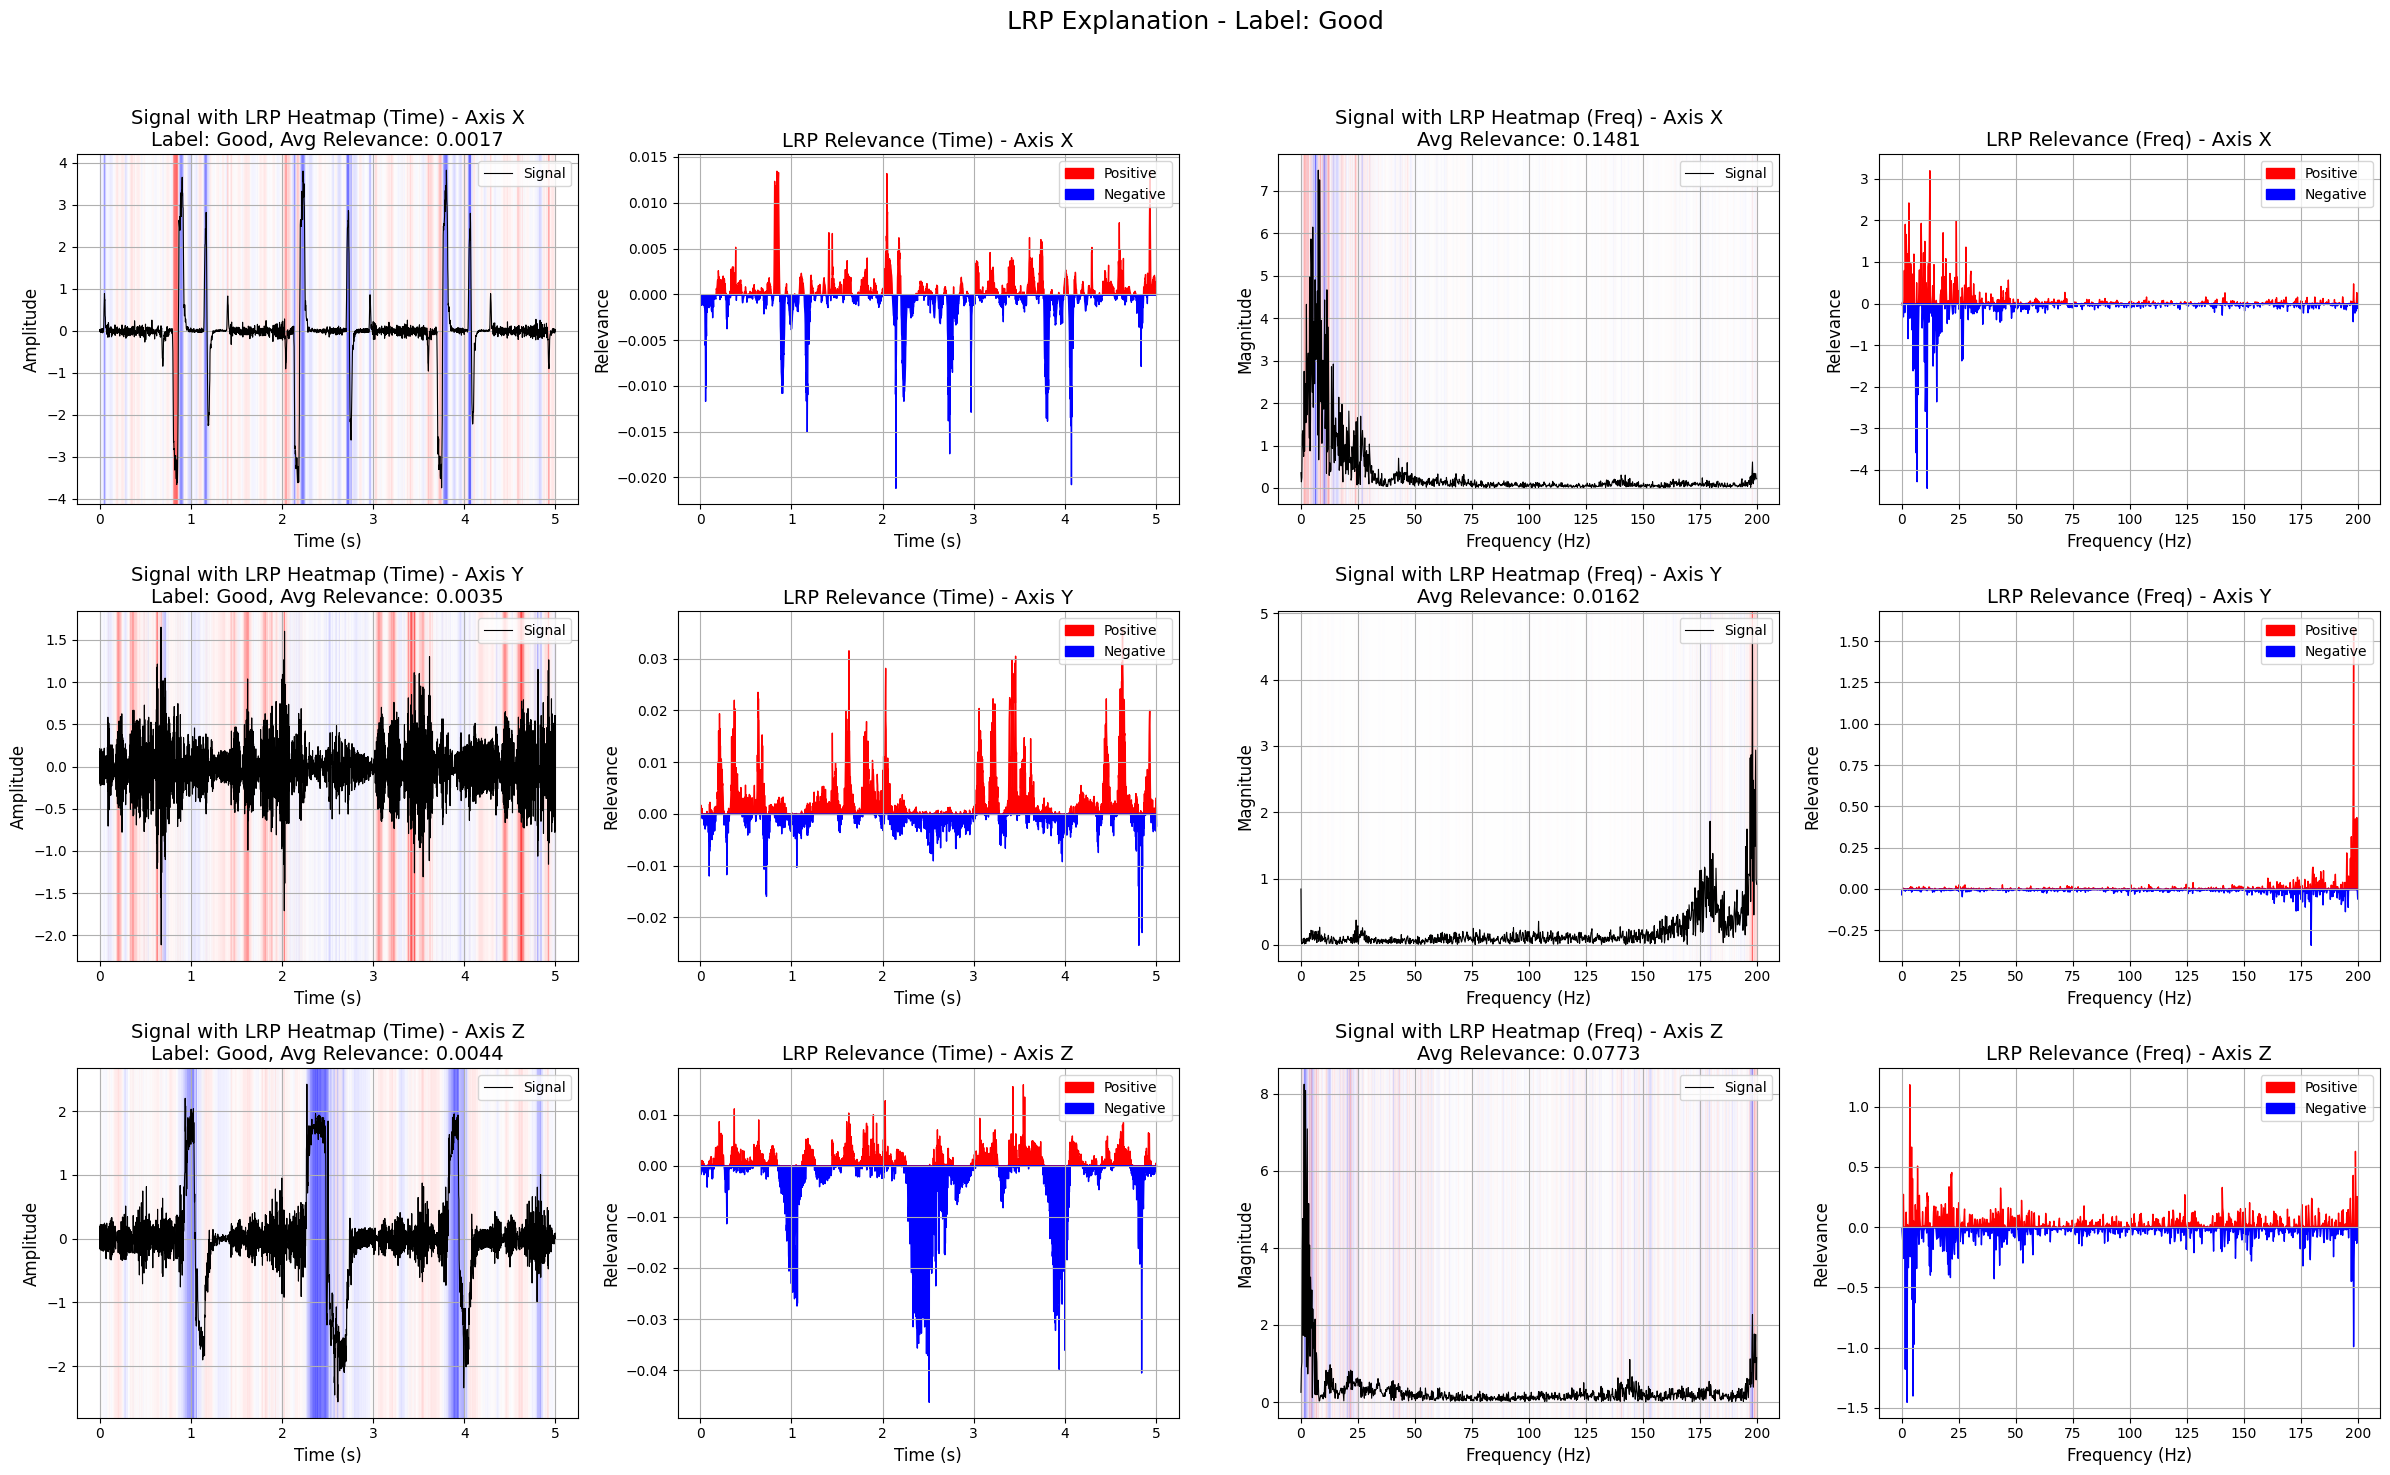

In [13]:
# Visualize the results
visualize_lrp_dft(
        relevance_time=relevance_time,
        relevance_freq=relevance_freq,
        signal_freq=signal_freq,
        input_signal=input_signal,
        freqs=freqs,
        predicted_label=predicted_label,
        k_max=1000,  # Plot up to 1000 Hz
        sampling_rate=400  # Placeholder, replace with your actual sampling rate
    )

In [14]:
# LRP visualization with common visualization function
 # write something similar to the common visualization for the frequency, so the relevance are colored over fft/dft signals
# in compute_dft_lrp_relevance why freqs are calculated by fft not dft?

In [78]:
get_layer_channels(freq_model, layer_name = 'fusion')

32

In [ ]:
# feature_layer = layer_names[len(layer_names)//2]  # Pick a middle layer
# Get the number of channels in that layer
# num_channels = get_layer_channels(model, feature_layer)
# conditions = [{feature_layer: list(range(num_channels)), "y": [target_label]}]

In [84]:
heatmap, attr = compute_crp_relevance(freq_model, sample, label)

['time_cnn.feature_extractor.0', 'time_cnn.feature_extractor.4', 'time_cnn.feature_extractor.8', 'time_cnn.classifier.0', 'time_cnn.classifier.3', 'freq_conv1', 'freq_conv2', 'fusion', 'classifier']
time_cnn.classifier.3
2
Most relevant channels in freq_conv2: [[18  1 29  9 12 24 30  7  4 14  0 13  8  3 15 10 25 31 21 22 23 16 17  5
  28 20  6 27 19 26  2 11]]


In [85]:
print(heatmap)

[-2.32124003e-05 -5.64320944e-04 -1.01927435e-04 ... -2.80830590e-03
  2.77248258e-03 -2.15911027e-03]


[DEBUG] signal shape: (3, 2000)
[DEBUG] crp_heatmap shape: (3, 2000)
[DEBUG] crp_heatmap min: -0.03486035 max: 0.03720072 mean: 0.00016639092


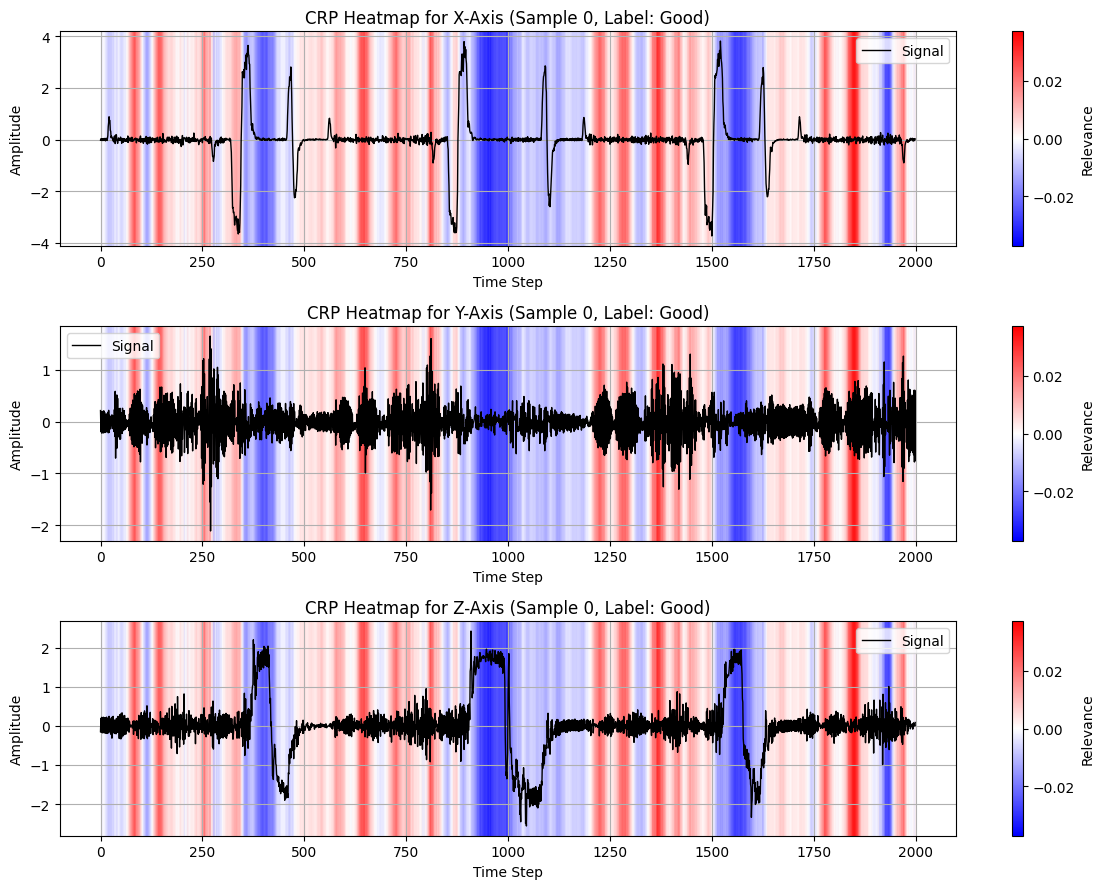

In [86]:
visualize_crp_heatmap(sample, heatmap, label)


In [15]:
relevance_time_fft, relevance_freq_fft, signal_freq_fft, relevance_timefreq_fft, signal_timefreq_fft, input_signal_fft, freqs_fft, predicted_label_fft = compute_fft_lrp_relevance(
        model=freq_model,
        sample=sample,
        label=None,
        signal_length=2000,
        sampling_rate=400,
        compute_timefreq=True,
        window_shift=50,  # Increased to reduce memory usage
        window_width=100,
        window_shape="rectangle"
    )

Input sample shape: torch.Size([1, 3, 2000])
Target label: 0
Input device in zennit_relevance: cuda:0
Input device in zennit_relevance_lrp: cuda:0
relevance_time_tensor shape before squeeze: (1, 3, 2000)
relevance_time shape after squeeze: (3, 2000)
input_signal shape: (3, 2000)
fft_lrp: Input relevance shape = (1, 2000), signal shape = (1, 2000)
fft_lrp: relevance_tensor shape = torch.Size([1, 2000]), signal_tensor shape = torch.Size([1, 2000])
fourier_transform: signal_tensor shape = torch.Size([1, 2000])
fourier_transform (FFT): signal_hat shape = torch.Size([1, 1001])
fft_lrp: signal_hat shape = torch.Size([1, 1001])
fft_lrp: relevance_normed shape = torch.Size([1, 2000])
fft_lrp: relevance_fft real part = tensor([[ 0.0693,  0.0843,  0.1170,  ...,  0.2071, -0.0662,  0.0304]],
       device='cuda:0')
fft_lrp: relevance_fft imag part = tensor([[ 0.0000,  0.2406, -0.0438,  ...,  0.2832,  0.2265,  0.0000]],
       device='cuda:0')
fft_lrp: relevance_hat real part before cpu = tensor([[

E:\Thesis\Datasets\CNC\utils\fft_lrp.py:24: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Copy.cpp:308.)
  arr = torch.from_numpy(arr).to(dtype=self.dtype)


In [16]:
# Global Attribution for FFT_LRP over frequency
summary_fft_freq = summarize_attributions(relevance_freq_fft)  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_fft_freq = []
for axis, values in summary_fft_freq.items():
    row = {"Axis": axis}
    row.update(values)
    data_fft_freq.append(row)

# Create the DataFrame
df_summary_fft_freq = pd.DataFrame(data_fft_freq)

# Display the DataFrame as a table
print(df_summary_fft_freq)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0             509    120.300179+  0.000000j   
1  Axis 1             485     17.246801+  0.000000j   
2  Axis 2             496     76.097256+  0.000000j   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0          0.236346+0.000000j             492   -120.787879+  0.000000j   
1          0.035560+0.000000j             516    -17.719405+  0.000000j   
2          0.153422+0.000000j             505    -79.331978+  0.000000j   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0         -0.245504+0.000000j          -0.487700+0.000000j   
1         -0.034340+0.000000j          -0.472604+0.000000j   
2         -0.157093+0.000000j          -3.234722+0.000000j   

   Average Relevance (Pos + Neg)  
0            -0.000487+0.000000j  
1            -0.000472+0.000000j  
2            -0.003231+0.000000j  


In [17]:
# Global Attribution for FFT_LRP over time frequency
summary_fft_timefreq = summarize_attributions(relevance_timefreq_fft)  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_fft_timefreq = []
for axis, values in summary_fft_timefreq.items():
    row = {"Axis": axis}
    row.update(values)
    data_fft_timefreq.append(row)

# Create the DataFrame
df_summary_fft_timefreq = pd.DataFrame(data_fft_timefreq)

# Display the DataFrame as a table
print(df_summary_fft_timefreq)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0           10128    493.925686+  0.000000j   
1  Axis 1           10297     46.612564+  0.000000j   
2  Axis 2            9983    258.879336+  0.000000j   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0          0.048768+0.000000j            9892   -487.778682+  0.000000j   
1          0.004527+0.000000j            9723    -45.877276+  0.000000j   
2          0.025932+0.000000j           10037   -250.318608+  0.000000j   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0         -0.049310+0.000000j           6.147004+0.000000j   
1         -0.004718+0.000000j           0.735288+0.000000j   
2         -0.024940+0.000000j           8.560728+0.000000j   

   Average Relevance (Pos + Neg)  
0             0.000307+0.000000j  
1             0.000037+0.000000j  
2             0.000428+0.000000j  


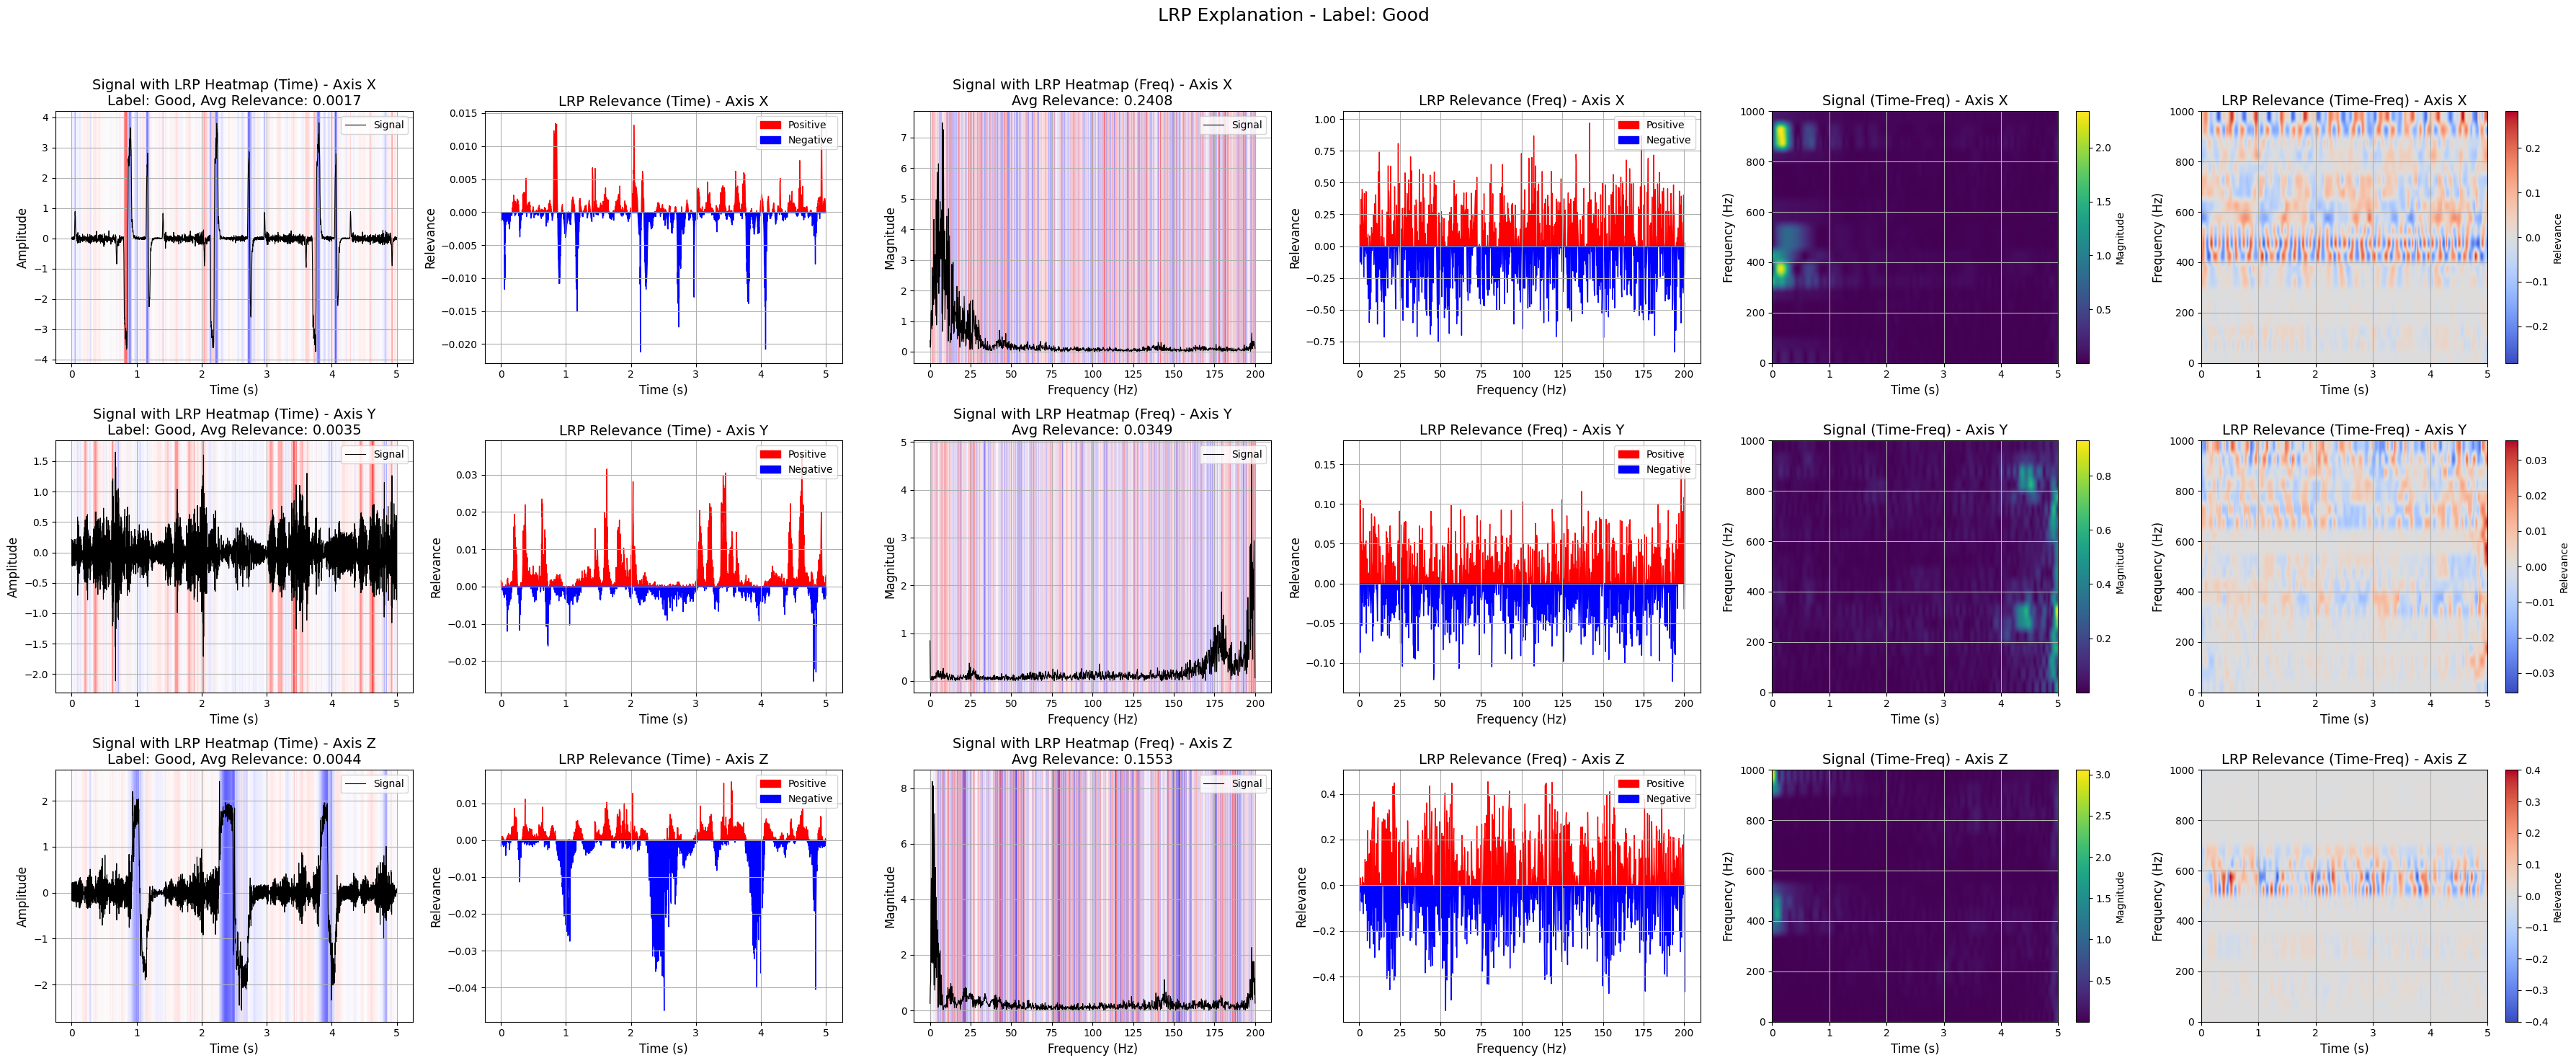

In [18]:
# Visualize
visualize_lrp_fft(
    relevance_time=relevance_time_fft,
    relevance_freq=relevance_freq_fft,
    signal_freq=signal_freq_fft,
    relevance_timefreq=relevance_timefreq_fft,
    signal_timefreq=signal_timefreq_fft,
    input_signal=input_signal_fft,
    freqs=freqs_fft,
    predicted_label=predicted_label_fft,
    signal_length=2000,
    sampling_rate=400,
    k_max=1000
)

#### FFT-LRP implementation?

Min relevance: -0.12784823775291443, Max relevance: 0.15628521144390106
 Maximum Absolute Attribution in Axis 0: 0.15628521144390106
 Maximum Absolute Attribution in Axis 1: 0.07753874361515045
 Maximum Absolute Attribution in Axis 2: 0.10316669940948486


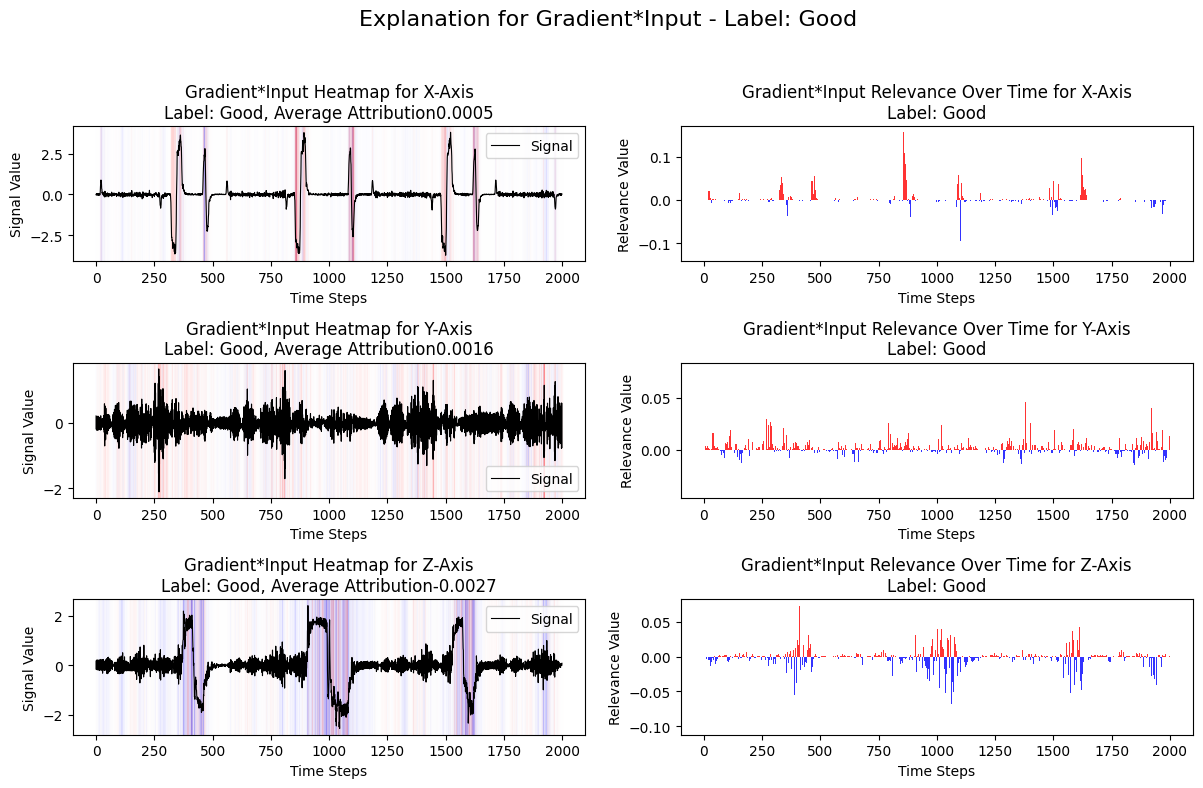

In [19]:
# Grad*Input
grad_input_attr, _ = grad_times_input_relevance(freq_model, sample)

print(f"Min relevance: {np.min(grad_input_attr.detach().cpu().numpy())}, Max relevance: {np.max(grad_input_attr.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, grad_input_attr, label, "Gradient*Input")


In [20]:
# Example usage
summary_g = summarize_attributions(grad_input_attr.detach().cpu().numpy())  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_g = []
for axis, values in summary_g.items():
    row = {"Axis": axis}
    row.update(values)
    data_g.append(row)

# Create the DataFrame
df_summary_g = pd.DataFrame(data_g)

# Display the DataFrame as a table
print(df_summary_g)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0             808                  5.238017   
1  Axis 1            1206                  5.467593   
2  Axis 2             895                  4.435965   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.006483            1192                 -4.241152   
1                    0.004534             794                 -2.259995   
2                    0.004956            1105                 -9.779348   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.003558                     0.996865   
1                   -0.002846                     3.207598   
2                   -0.008850                    -5.343384   

   Average Relevance (Pos + Neg)  
0                       0.000498  
1                       0.001604  
2                      -0.002672  


Min relevance: -0.04748854041099548, Max relevance: 0.11754529178142548
 Maximum Absolute Attribution in Axis 0: 0.11754529178142548
 Maximum Absolute Attribution in Axis 1: 0.027173280715942383
 Maximum Absolute Attribution in Axis 2: 0.04748854041099548


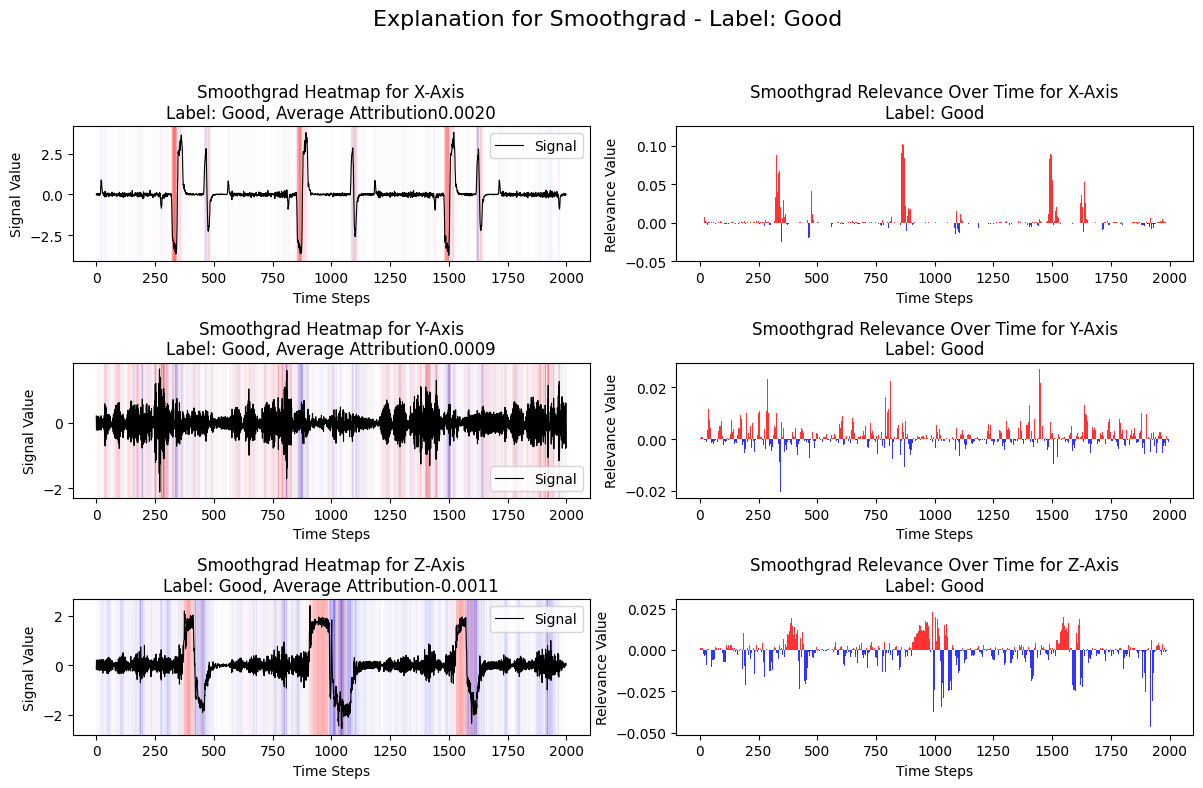

In [21]:

# SmoothGrad
smoothgrad_attr, _ = smoothgrad_relevance(freq_model, sample)
print(f"Min relevance: {np.min(smoothgrad_attr.detach().cpu().numpy())}, Max relevance: {np.max(smoothgrad_attr.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, smoothgrad_attr, label, "Smoothgrad")


Min relevance: -0.011340141296386719, Max relevance: 0.03783893585205078
 Maximum Absolute Attribution in Axis 0: 0.03783893585205078
 Maximum Absolute Attribution in Axis 1: 0.01847076416015625
 Maximum Absolute Attribution in Axis 2: 0.01623058319091797


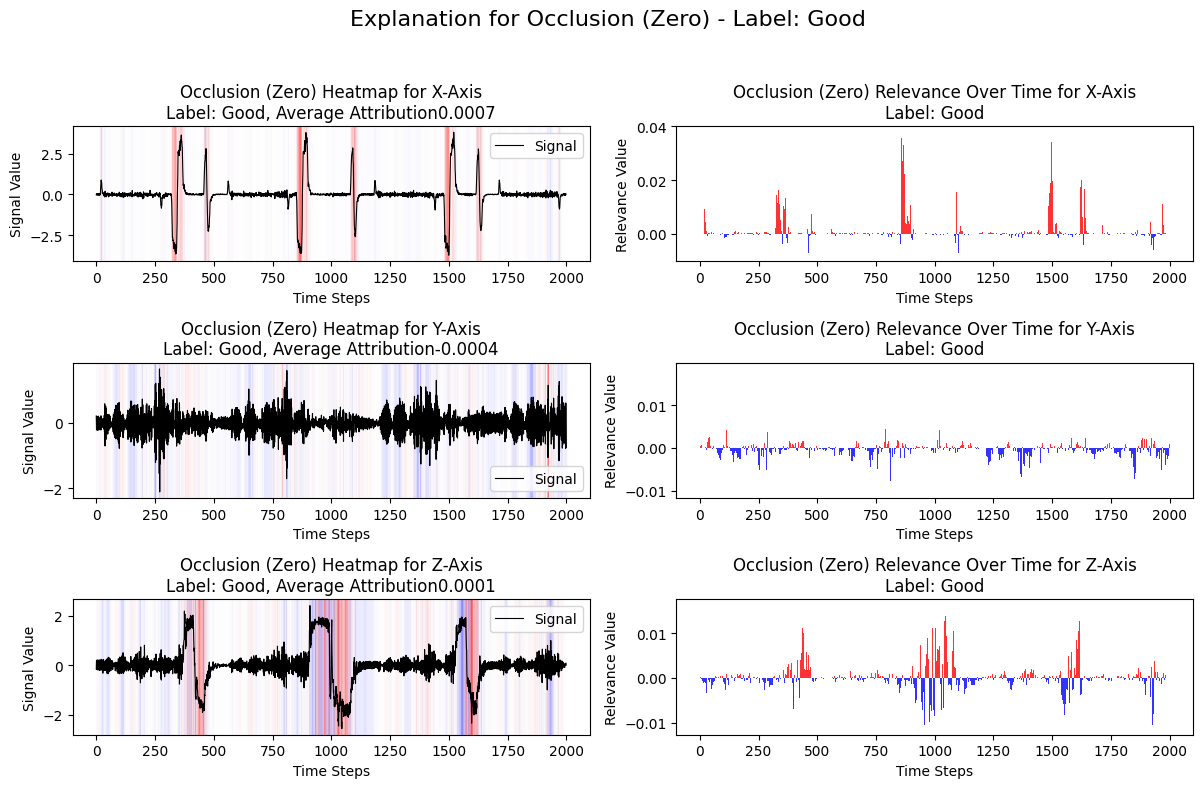

In [22]:
# Occlusion (zero-based occlusion)
occlusion_attr_zero, _ = occlusion_signal_relevance(freq_model, sample, occlusion_type="zero")
print(f"Min relevance: {np.min(occlusion_attr_zero.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_zero.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, occlusion_attr_zero, label, "Occlusion (Zero)")


Min relevance: -0.1125340461730957, Max relevance: 0.0814371109008789
 Maximum Absolute Attribution in Axis 0: 0.1125340461730957
 Maximum Absolute Attribution in Axis 1: 0.1125340461730957
 Maximum Absolute Attribution in Axis 2: 0.1125340461730957


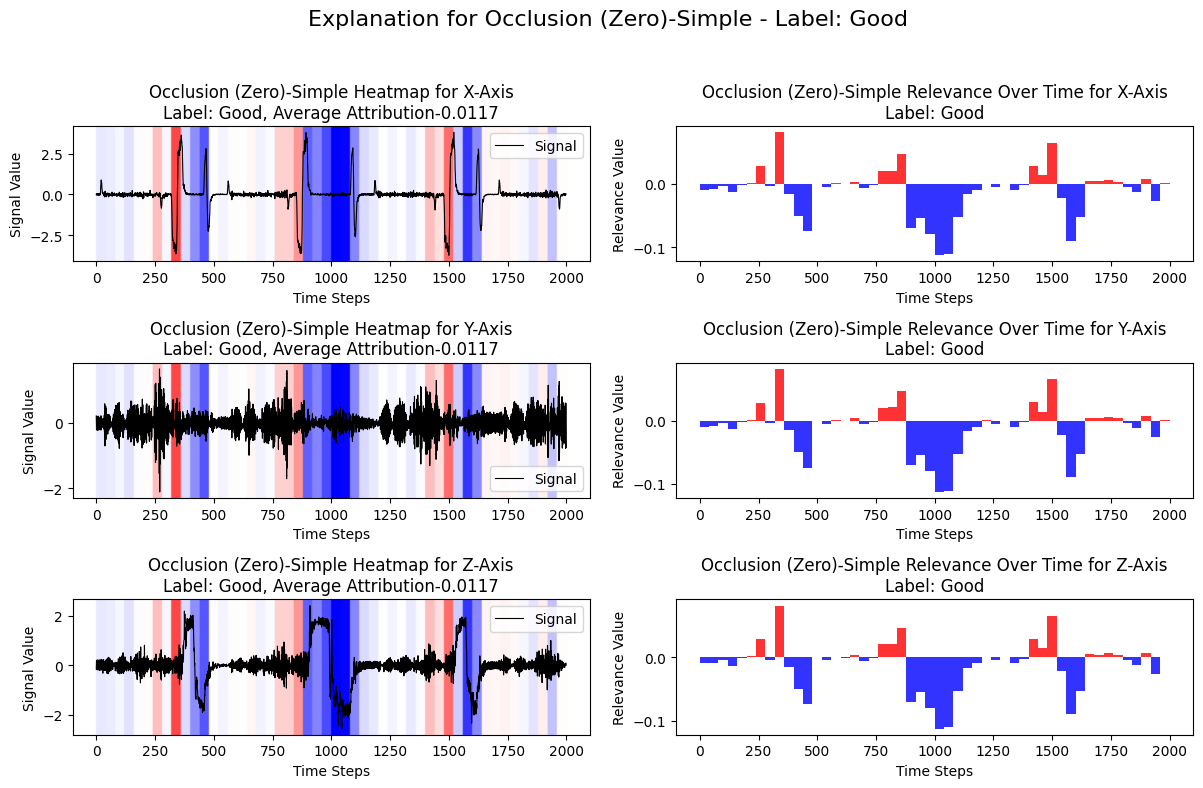

In [23]:
# Occlusion (zero-based occlusion)
occlusion_attr_zero_simple, _ = occlusion_simpler_relevance(freq_model, sample, occlusion_type="zero")
print(f"Min relevance: {np.min(occlusion_attr_zero_simple.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_zero_simple.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, occlusion_attr_zero_simple, label, "Occlusion (Zero)-Simple")


Min relevance: -0.1487131118774414, Max relevance: 0.12966012954711914
 Maximum Absolute Attribution in Axis 0: 0.1487131118774414
 Maximum Absolute Attribution in Axis 1: 0.1487131118774414
 Maximum Absolute Attribution in Axis 2: 0.1487131118774414


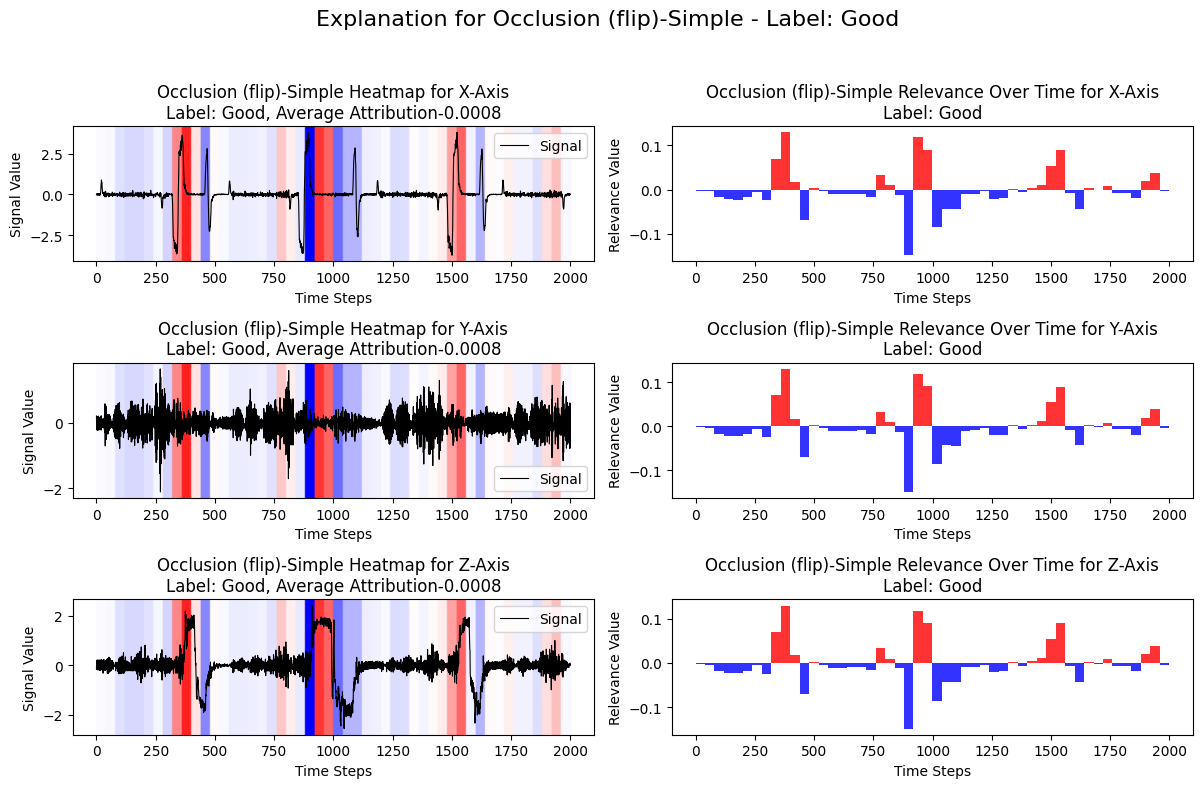

In [24]:
# Occlusion (zero-based occlusion)
occlusion_attr_zero_simple, _ = occlusion_simpler_relevance(freq_model, sample, occlusion_type="flip")
print(f"Min relevance: {np.min(occlusion_attr_zero_simple.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_zero_simple.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, occlusion_attr_zero_simple, label, "Occlusion (flip)-Simple")


Min relevance: -0.02924346923828125, Max relevance: 0.058573246002197266
 Maximum Absolute Attribution in Axis 0: 0.058573246002197266
 Maximum Absolute Attribution in Axis 1: 0.041141510009765625
 Maximum Absolute Attribution in Axis 2: 0.043639183044433594


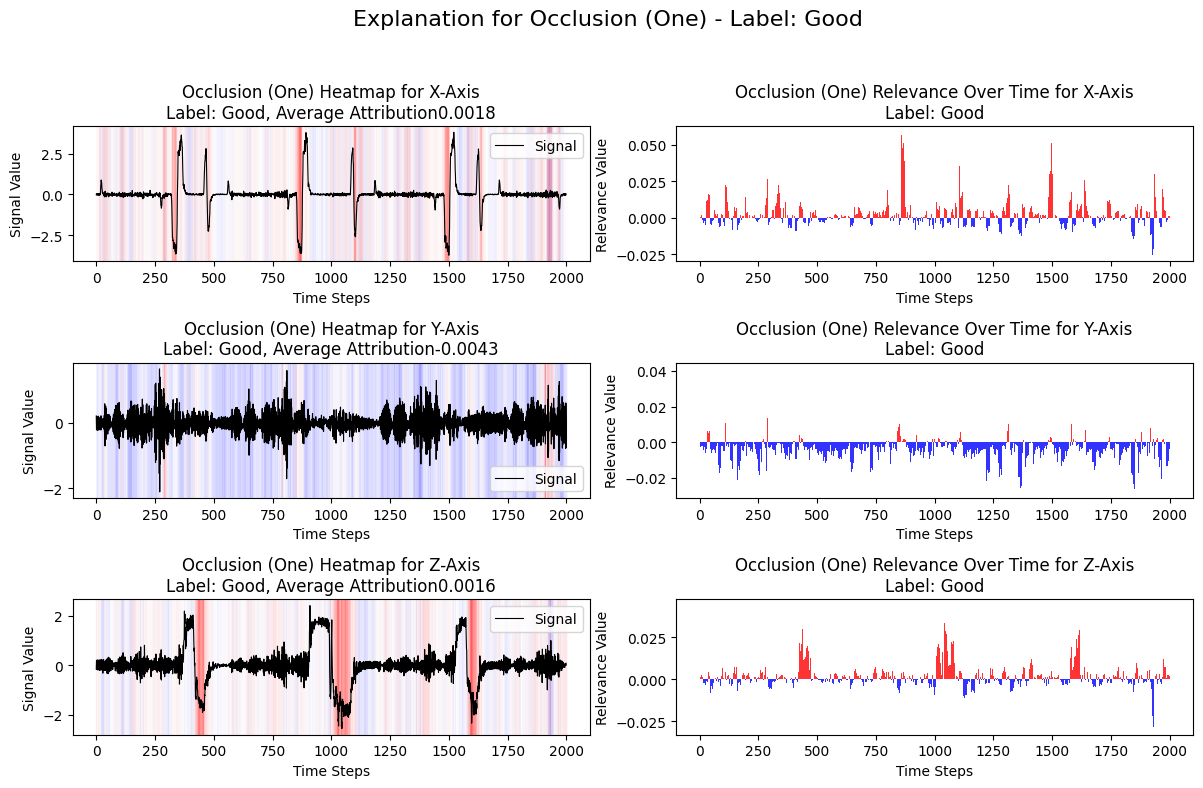

In [25]:
# Occlusion (one occlusion)
occlusion_attr_one, _ = occlusion_signal_relevance(freq_model, sample, occlusion_type="one")
print(f"Min relevance: {np.min(occlusion_attr_one.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_one.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, occlusion_attr_one, label, "Occlusion (One)")


Min relevance: -0.029466629028320312, Max relevance: 0.042491912841796875
 Maximum Absolute Attribution in Axis 0: 0.042491912841796875
 Maximum Absolute Attribution in Axis 1: 0.024446487426757812
 Maximum Absolute Attribution in Axis 2: 0.03232765197753906


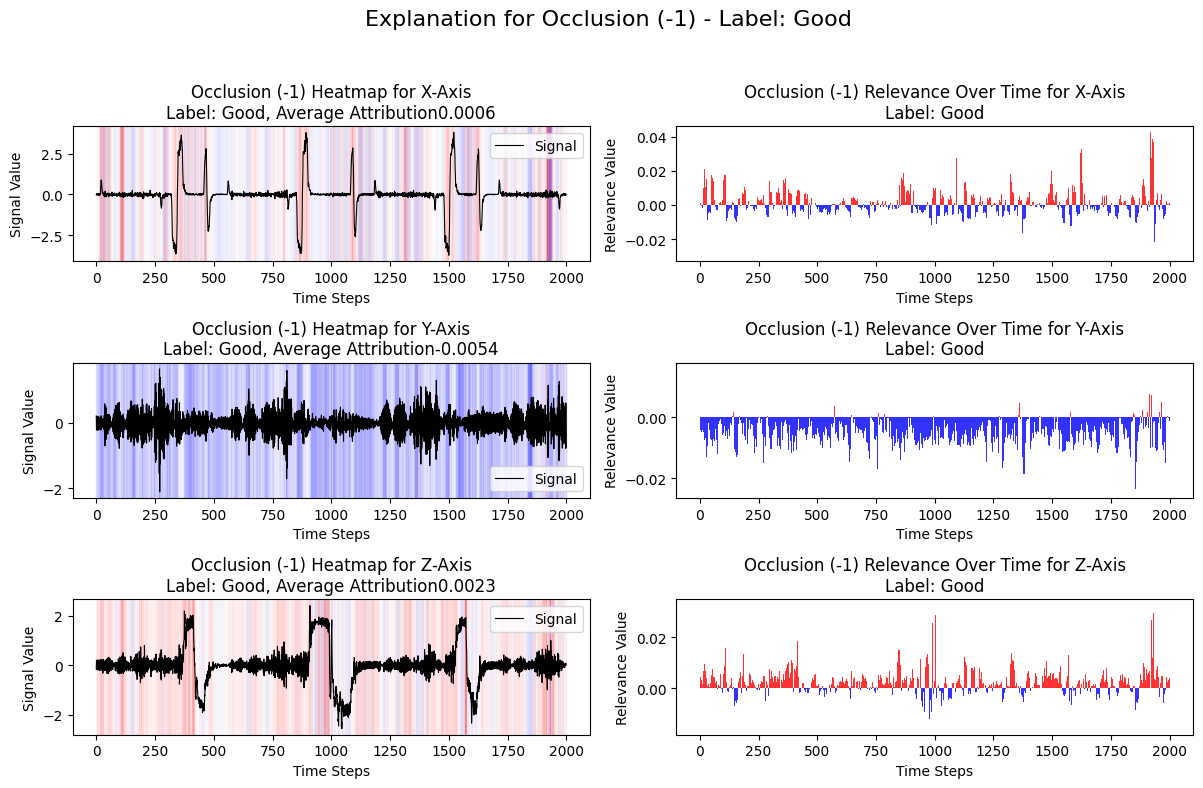

In [26]:
# Occlusion (-one occlusion)
occlusion_attr_mone, _ = occlusion_signal_relevance(freq_model, sample, occlusion_type="mone")
print(f"Min relevance: {np.min(occlusion_attr_mone.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_mone.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, occlusion_attr_mone, label, "Occlusion (-1)")


Min relevance: -0.028512954711914062, Max relevance: 0.11841535568237305
 Maximum Absolute Attribution in Axis 0: 0.11841535568237305
 Maximum Absolute Attribution in Axis 1: 0.04022026062011719
 Maximum Absolute Attribution in Axis 2: 0.0746145248413086


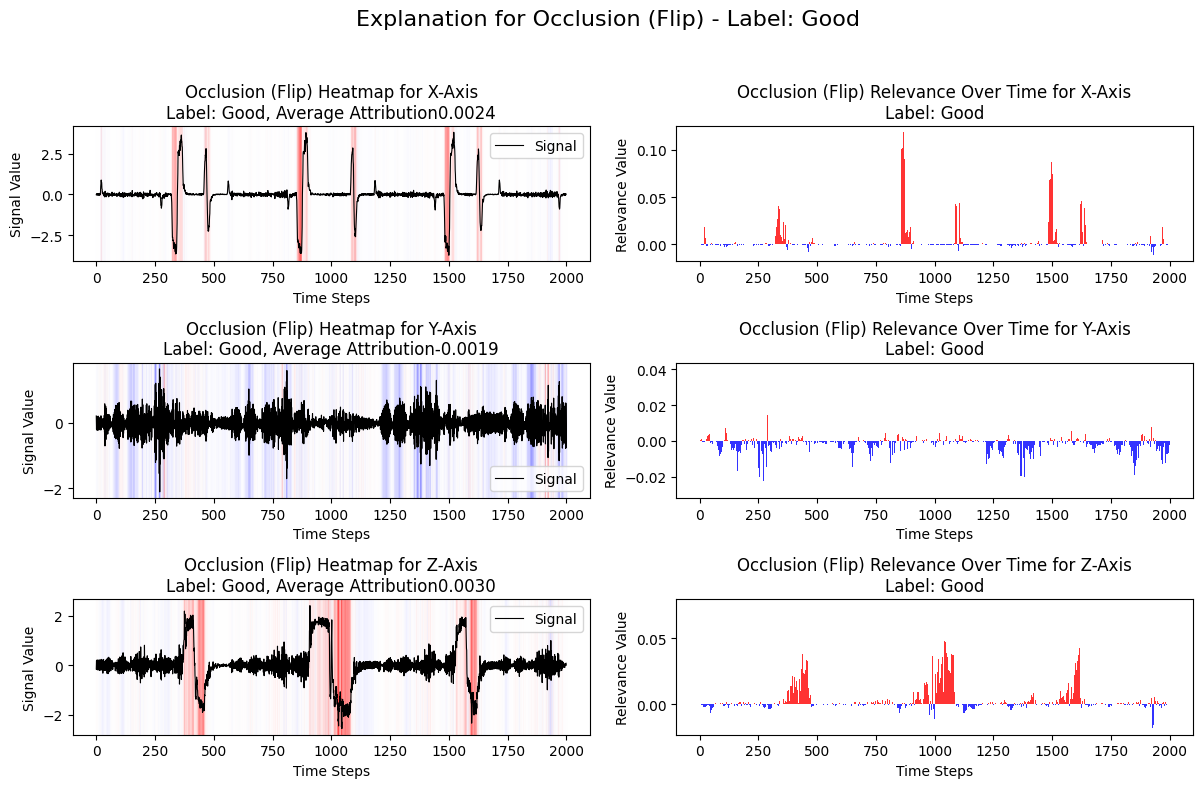

In [27]:
# Occlusion (flip occlusion)
occlusion_attr_flip, _ = occlusion_signal_relevance(freq_model, sample, occlusion_type="flip")
print(f"Min relevance: {np.min(occlusion_attr_flip.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_flip.detach().cpu().numpy())}")

visualize_with_label_attribution(sample, occlusion_attr_flip, label, "Occlusion (Flip)")


In [50]:
# Load a Bad sample

# Load a batch
sample_batch, label_batch = next(iter(train_loader))

random.seed(44)
# Choose a random index
random_index_b = random.randint(0, len(sample_batch) - 1)

# Select the random sample and its corresponding label
sample_b = sample_batch[random_index_b]  # Shape: (3, 10000)
label_b = label_batch[random_index_b]    # Shape: ()



sample_b = sample_b.to(device)
label_b = label_b.to(device)

_, predicted_label_b = predict_single(freq_model, sample_b)


# Print the selected sample and label
print(f"Random Index: {random_index_b}, Predicted_label:{predicted_label_b}, True_label:{label_b}")
print(sample_b,sample_b.shape)


Random Index: 104, Predicted_label:1, True_label:1
tensor([[-0.0181, -0.0431, -0.0387,  ...,  0.0043,  0.0948,  0.0274],
        [-0.9912, -0.7366, -1.4459,  ...,  0.4048, -0.4217,  0.7205],
        [ 0.1245, -0.1688,  0.0925,  ..., -0.3167,  0.1196, -0.2921]],
       device='cuda:0') torch.Size([3, 2000])


Sample device: cuda:0
Model device: cuda:0
Target device: cuda:0
Input device in zennit_relevance: cuda:0
Input device in zennit_relevance_lrp: cuda:0
Sample 28 Label: Bad


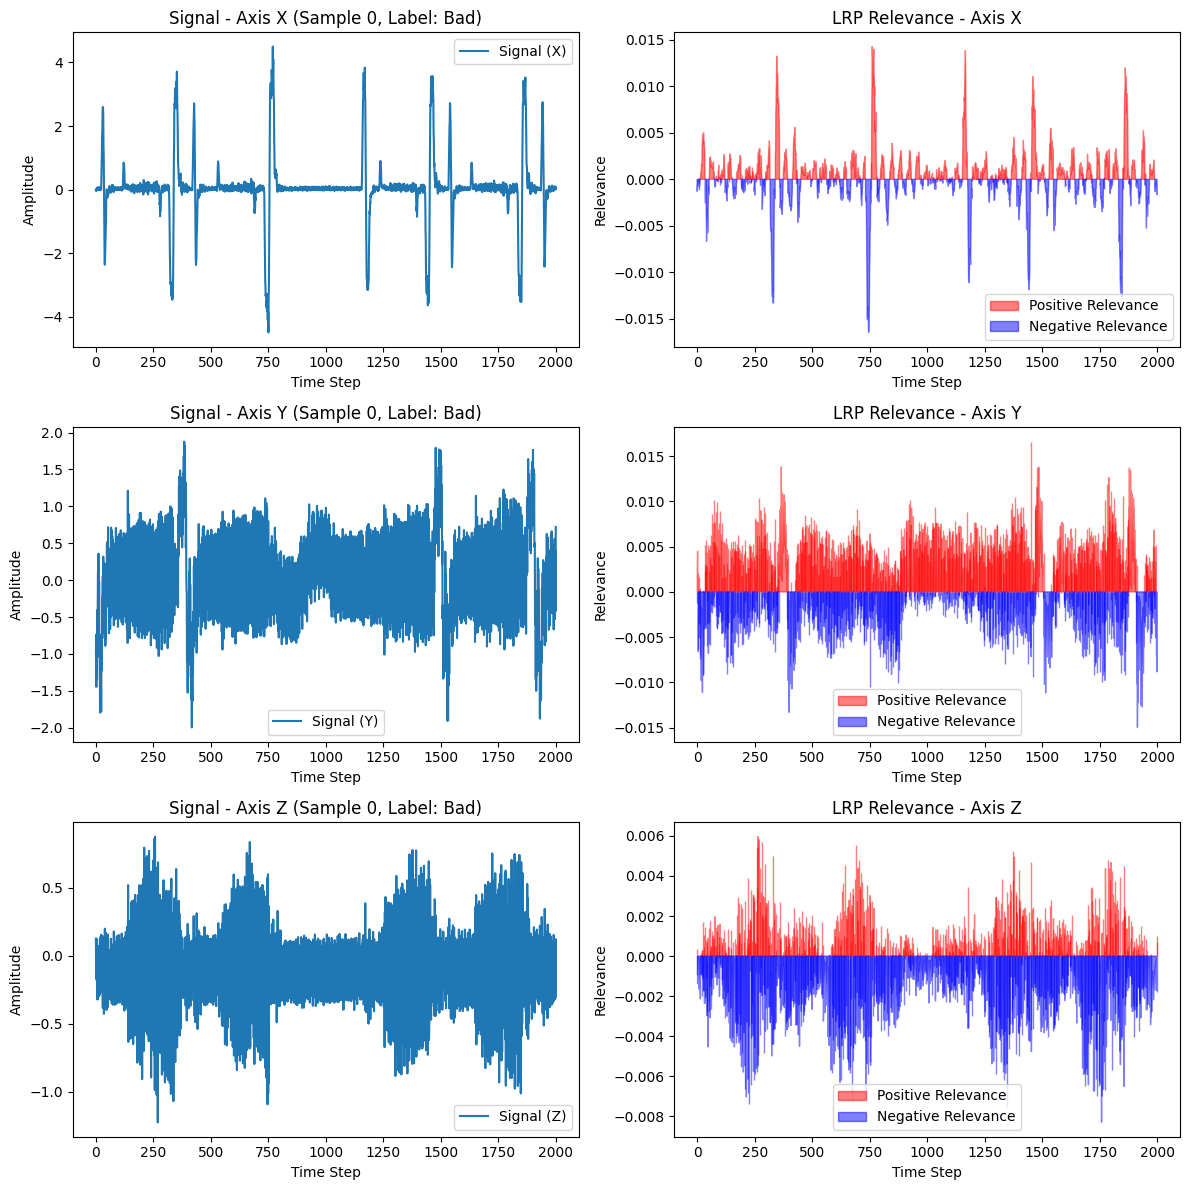

In [51]:
relevance_b, input_signal_b, final_label_b = compute_lrp_relevance(
    model=freq_model,
    sample=sample_b,  # Shape: (3, 10000) or torch tensor
    label=label_b,  # Use true label or None for prediction
    device=device
)
print(f"Sample {random_index} Label: {'Good' if final_label_b == 0 else 'Bad'}")

# Visualize LRP relevances (use your existing `visualize_lrp_relevance_single_sample` function)
visualize_lrp_single_sample(
    signal=input_signal_b,
    relevance=relevance_b,
    label=final_label_b)

Min relevance: -0.07882195711135864, Max relevance: 0.08806973695755005
 Maximum Absolute Attribution in Axis 0: 0.08806973695755005
 Maximum Absolute Attribution in Axis 1: 0.07880678027868271
 Maximum Absolute Attribution in Axis 2: 0.052968692034482956


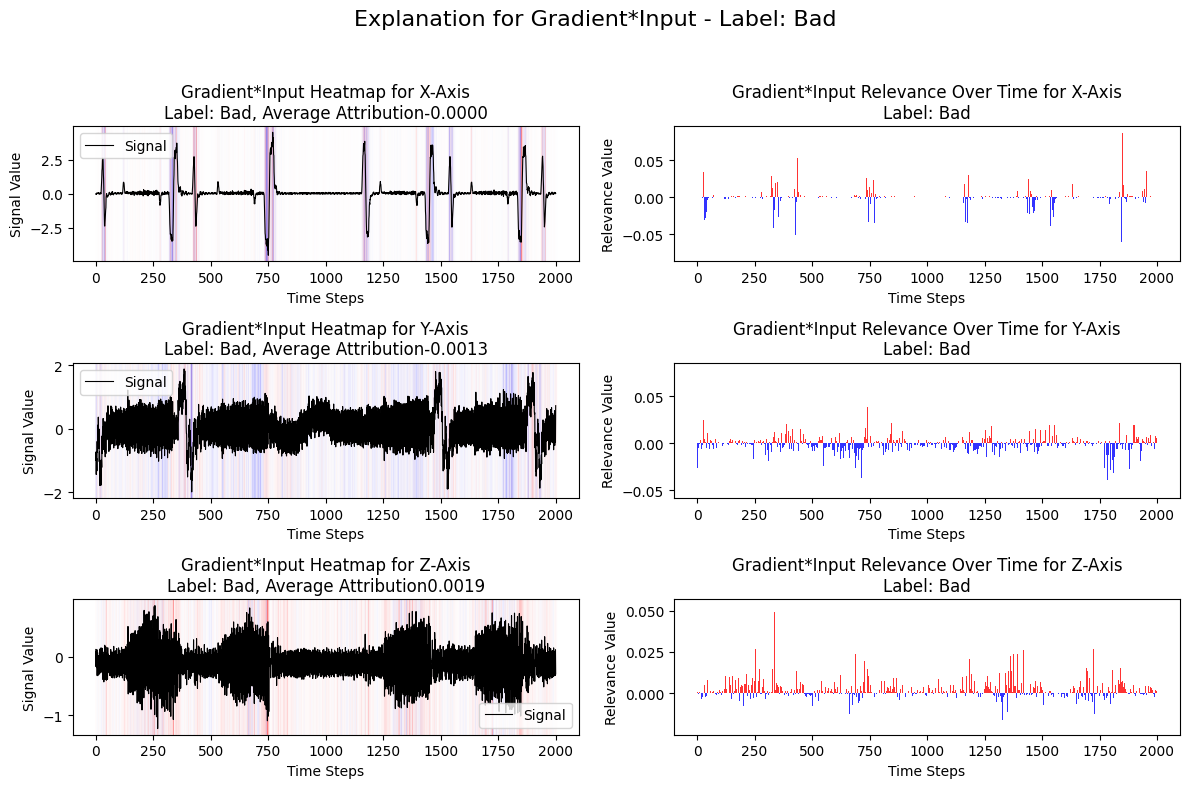

In [52]:
# Grad*Input
grad_input_attr_b, _ = grad_times_input_relevance(freq_model, sample_b)
print(f"Min relevance: {np.min(grad_input_attr_b.detach().cpu().numpy())}, Max relevance: {np.max(grad_input_attr_b.detach().cpu().numpy())}")
visualize_with_label_attribution(sample_b, grad_input_attr_b, label_b, "Gradient*Input")

In [53]:
# Example usage
summary_b_g = summarize_attributions(grad_input_attr_b.detach().cpu().numpy())  # Pass your attributions here

# Flatten the summary dictionary and create a DataFrame
data_b_g = []
for axis, values in summary_b_g.items():
    row = {"Axis": axis}
    row.update(values)
    data_b_g.append(row)

# Create the DataFrame
df_summary_b_g = pd.DataFrame(data_b_g)

# Display the DataFrame as a table
print(df_summary_b_g)


     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0            1077                  3.278661   
1  Axis 1             872                  4.089097   
2  Axis 2            1284                  5.202026   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.003044             923                 -3.359612   
1                    0.004689            1128                 -6.639393   
2                    0.004051             716                 -1.495448   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.003640                    -0.080951   
1                   -0.005886                    -2.550296   
2                   -0.002089                     3.706578   

   Average Relevance (Pos + Neg)  
0                      -0.000040  
1                      -0.001275  
2                       0.001853  


Min relevance: -0.12931321561336517, Max relevance: 0.04380234703421593
 Maximum Absolute Attribution in Axis 0: 0.12931321561336517
 Maximum Absolute Attribution in Axis 1: 0.04380234703421593
 Maximum Absolute Attribution in Axis 2: 0.04209531098604202


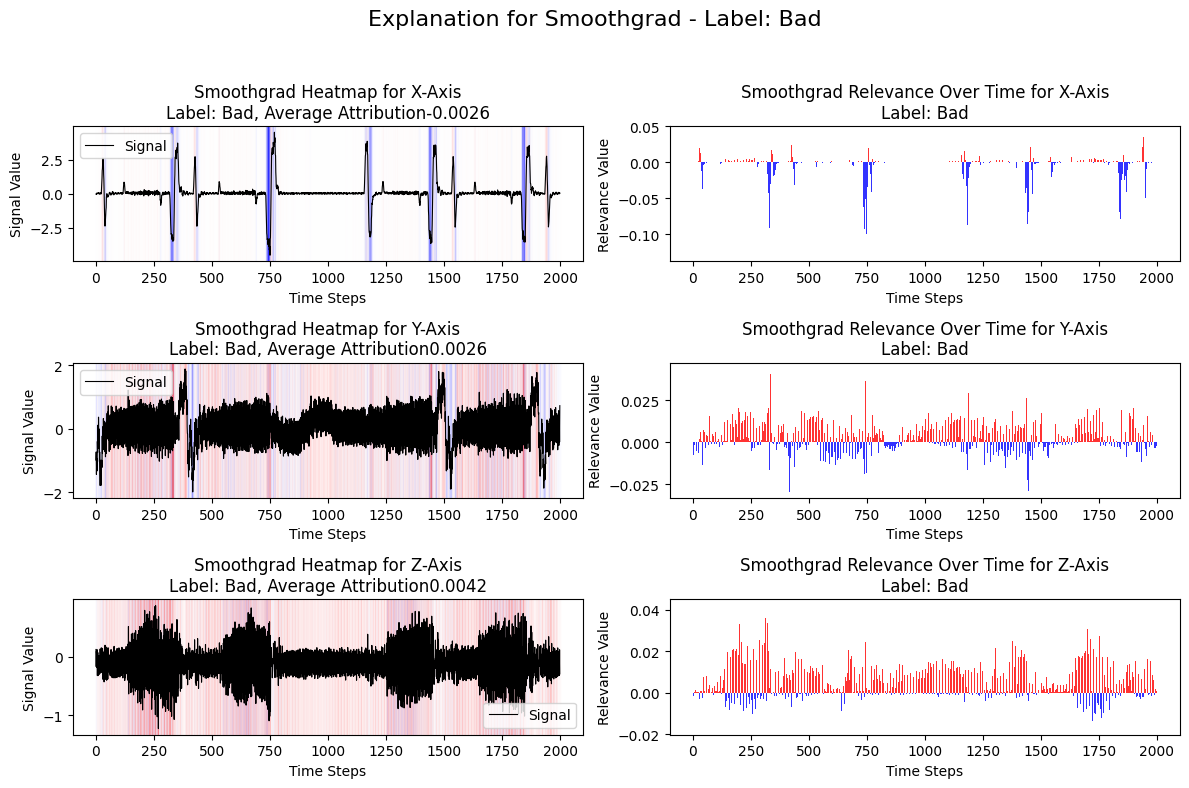

In [54]:
# SmoothGrad
smoothgrad_attr_b, _ = smoothgrad_relevance(freq_model, sample_b)
print(f"Min relevance: {np.min(smoothgrad_attr_b.detach().cpu().numpy())}, Max relevance: {np.max(smoothgrad_attr_b.detach().cpu().numpy())}")
visualize_with_label_attribution(sample_b, smoothgrad_attr_b, label_b, "Smoothgrad")


In [55]:
# Example usage
summary_b_sg = summarize_attributions(smoothgrad_attr_b.detach().cpu().numpy())  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_b_sg = []
for axis, values in summary_b_sg.items():
    row = {"Axis": axis}
    row.update(values)
    data_b_sg.append(row)

# Create the DataFrame
df_summary_b_sg = pd.DataFrame(data_b_sg)

# Display the DataFrame as a table
print(df_summary_b_sg)# Flatten the summary dictionary and create a DataFrame


     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0            1208                  1.905292   
1  Axis 1            1134                  8.555403   
2  Axis 2            1219                 10.232156   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.001577             792                 -7.087239   
1                    0.007544             866                 -3.384742   
2                    0.008394             781                 -1.863852   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.008949                    -5.181948   
1                   -0.003908                     5.170661   
2                   -0.002386                     8.368303   

   Average Relevance (Pos + Neg)  
0                      -0.002591  
1                       0.002585  
2                       0.004184  


Min relevance: -0.018729209899902344, Max relevance: 0.02170085906982422
 Maximum Absolute Attribution in Axis 0: 0.018729209899902344
 Maximum Absolute Attribution in Axis 1: 0.02170085906982422
 Maximum Absolute Attribution in Axis 2: 0.008160591125488281


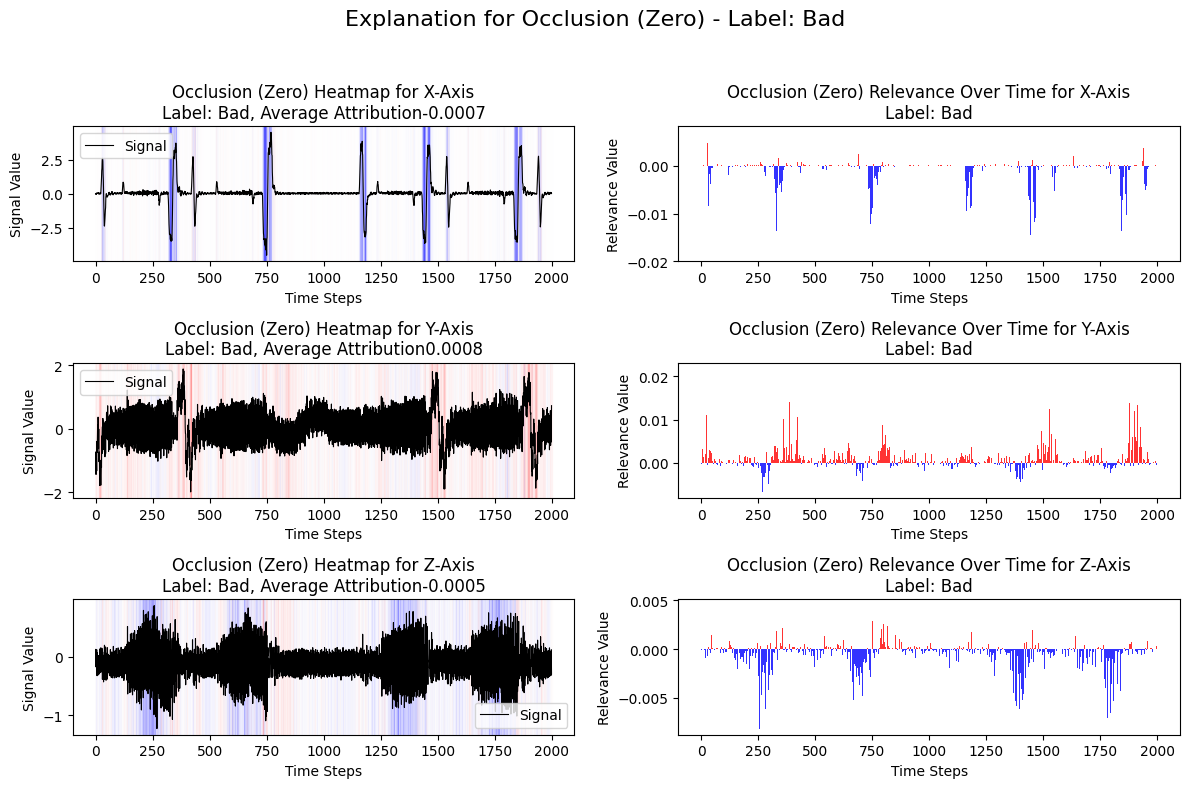

In [56]:
# Occlusion (zero-based occlusion)
occlusion_attr_zero_b, _ = occlusion_signal_relevance(freq_model, sample_b, occlusion_type="zero")
print(f"Min relevance: {np.min(occlusion_attr_zero_b.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_zero_b.detach().cpu().numpy())}")
visualize_with_label_attribution(sample_b, occlusion_attr_zero_b, label_b, "Occlusion (Zero)")

Min relevance: -0.027444839477539062, Max relevance: 0.03622150421142578
 Maximum Absolute Attribution in Axis 0: 0.02451038360595703
 Maximum Absolute Attribution in Axis 1: 0.03622150421142578
 Maximum Absolute Attribution in Axis 2: 0.027444839477539062


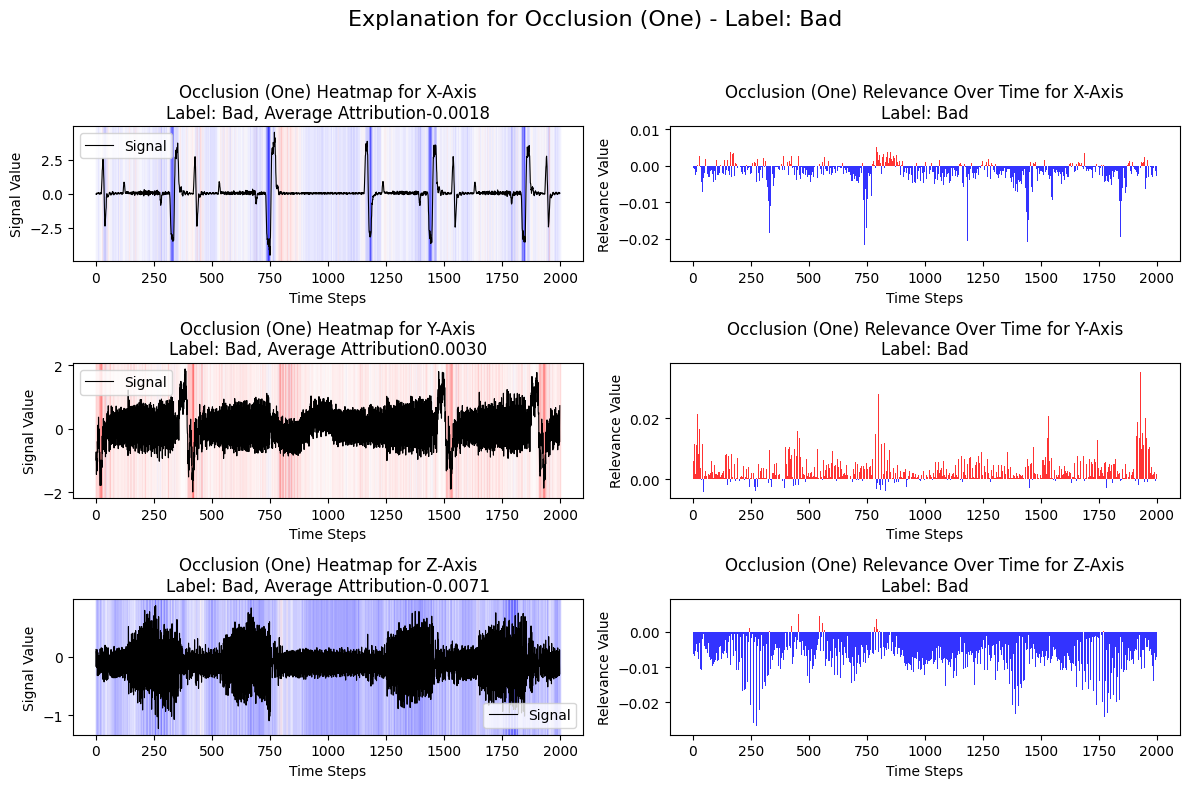

In [57]:
# Occlusion (one occlusion)
occlusion_attr_one_b, _ = occlusion_signal_relevance(freq_model, sample_b, occlusion_type="one")
print(f"Min relevance: {np.min(occlusion_attr_one_b.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_one_b.detach().cpu().numpy())}")
visualize_with_label_attribution(sample_b, occlusion_attr_one_b, label_b, "Occlusion (One)")

Min relevance: -0.022882461547851562, Max relevance: 0.027680397033691406
 Maximum Absolute Attribution in Axis 0: 0.017896175384521484
 Maximum Absolute Attribution in Axis 1: 0.027680397033691406
 Maximum Absolute Attribution in Axis 2: 0.022882461547851562


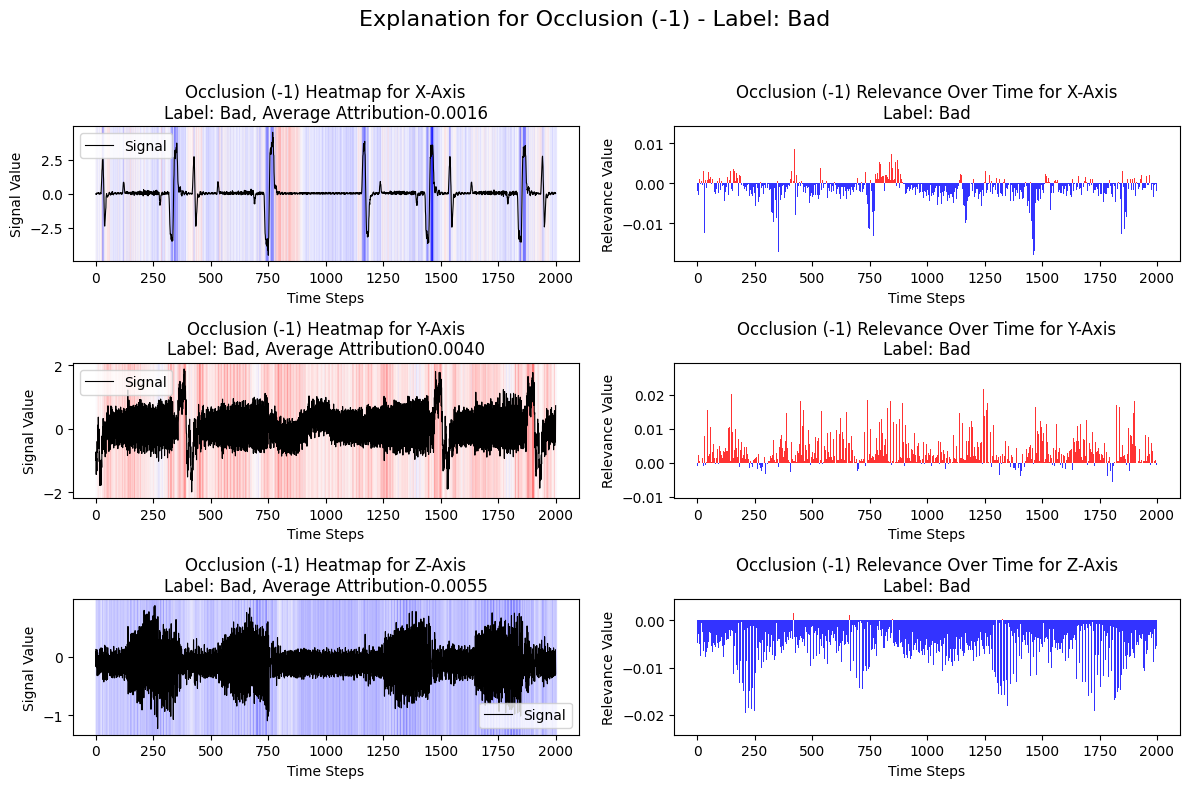

In [58]:
# Occlusion (-one occlusion)
occlusion_attr_mone_b, _ = occlusion_signal_relevance(freq_model, sample_b, occlusion_type="mone")
print(f"Min relevance: {np.min(occlusion_attr_mone_b.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_mone_b.detach().cpu().numpy())}")
visualize_with_label_attribution(sample_b, occlusion_attr_mone_b, label_b, "Occlusion (-1)")

Min relevance: -0.038794517517089844, Max relevance: 0.05312299728393555
 Maximum Absolute Attribution in Axis 0: 0.038794517517089844
 Maximum Absolute Attribution in Axis 1: 0.05312299728393555
 Maximum Absolute Attribution in Axis 2: 0.025388240814208984


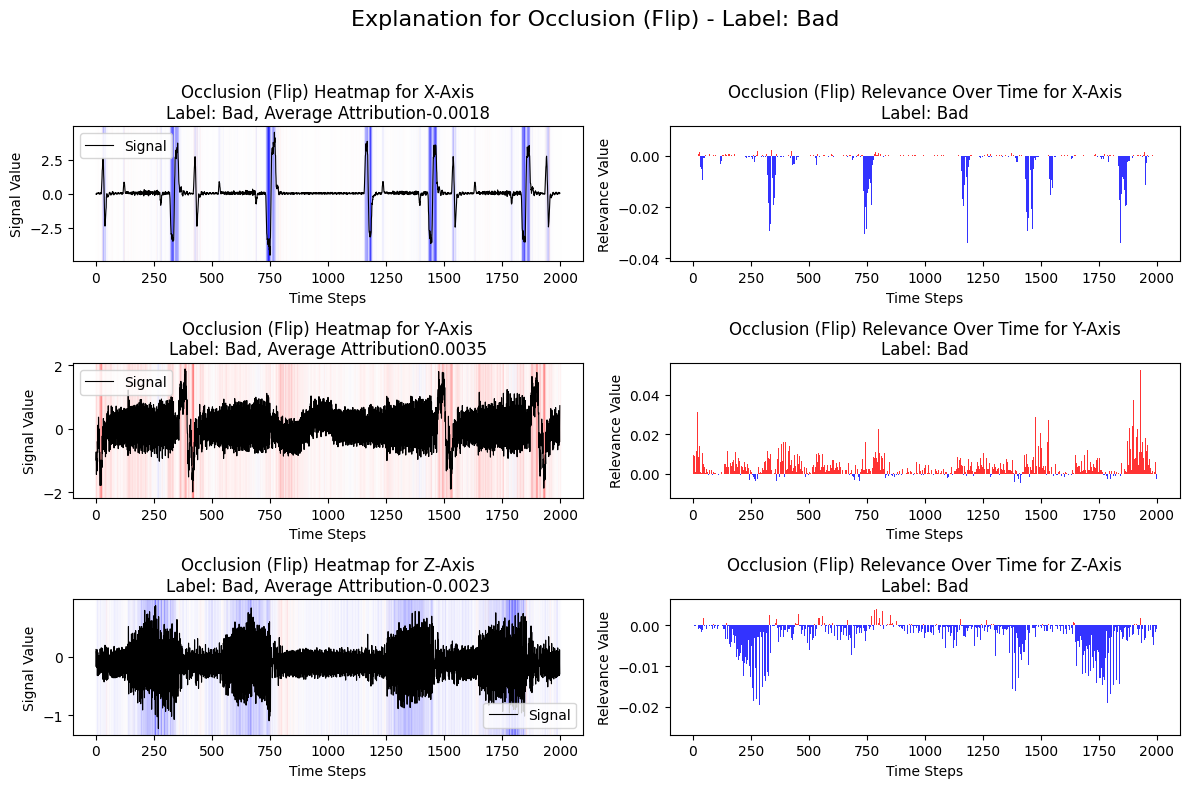

In [59]:

# Occlusion (e.g., zero-based occlusion)
occlusion_attr_flip_b, _ = occlusion_signal_relevance(freq_model, sample_b, occlusion_type="flip")
print(f"Min relevance: {np.min(occlusion_attr_flip_b.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_flip_b.detach().cpu().numpy())}")

visualize_with_label_attribution(sample_b, occlusion_attr_flip_b, label_b, "Occlusion (Flip)")


Min relevance: -0.01645870879292488, Max relevance: 0.01659443788230419
 Maximum Absolute Attribution in Axis 0: 0.01645870879292488
 Maximum Absolute Attribution in Axis 1: 0.01659443788230419
 Maximum Absolute Attribution in Axis 2: 0.008298205211758614


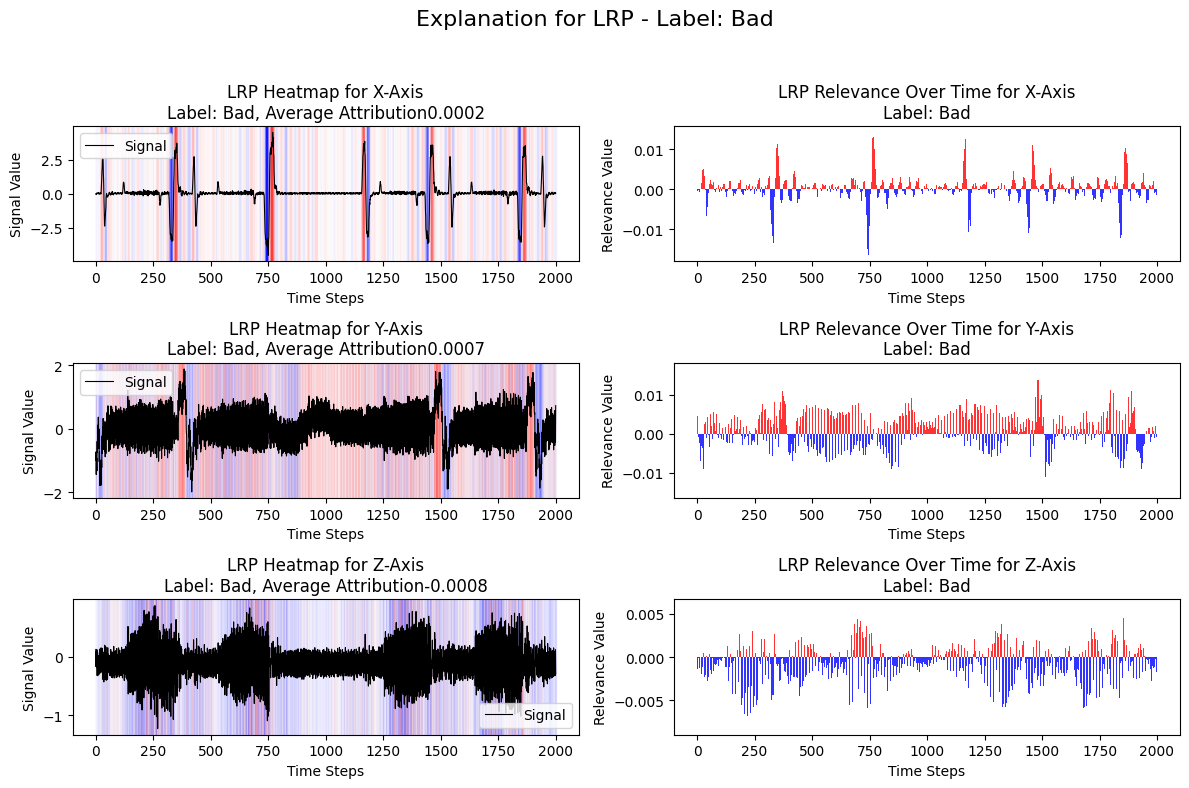

In [60]:

print(f"Min relevance: {np.min(relevance_b)}, Max relevance: {np.max(relevance_b)}")
visualize_with_label_attribution(sample_b, relevance_b, label_b, "LRP")


In [61]:
summary_b_of = summarize_attributions(occlusion_attr_flip_b.detach().cpu().numpy())  # Pass your attributions here

# Flatten the summary dictionary and create a DataFrame
data = []
for axis, values in summary_b_of.items():
    row = {"Axis": axis}
    row.update(values)
    data.append(row)

# Create the DataFrame
df_summary = pd.DataFrame(data)

# Display the DataFrame as a table
print(df_summary)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0             802                  0.226437   
1  Axis 1            1597                  7.291996   
2  Axis 2             431                  0.224464   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.000282            1183                 -3.743249   
1                    0.004566             401                 -0.372177   
2                    0.000521            1560                 -4.822880   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.003164                    -3.516812   
1                   -0.000928                     6.919819   
2                   -0.003092                    -4.598416   

   Average Relevance (Pos + Neg)  
0                      -0.001772  
1                       0.003463  
2                      -0.002310  


Sample device: cuda:0
Model device: cuda:0
Target device: cuda:0
Input device in zennit_relevance: cuda:0
Input device in zennit_relevance_lrp: cuda:0
Sample 104 Label: Bad


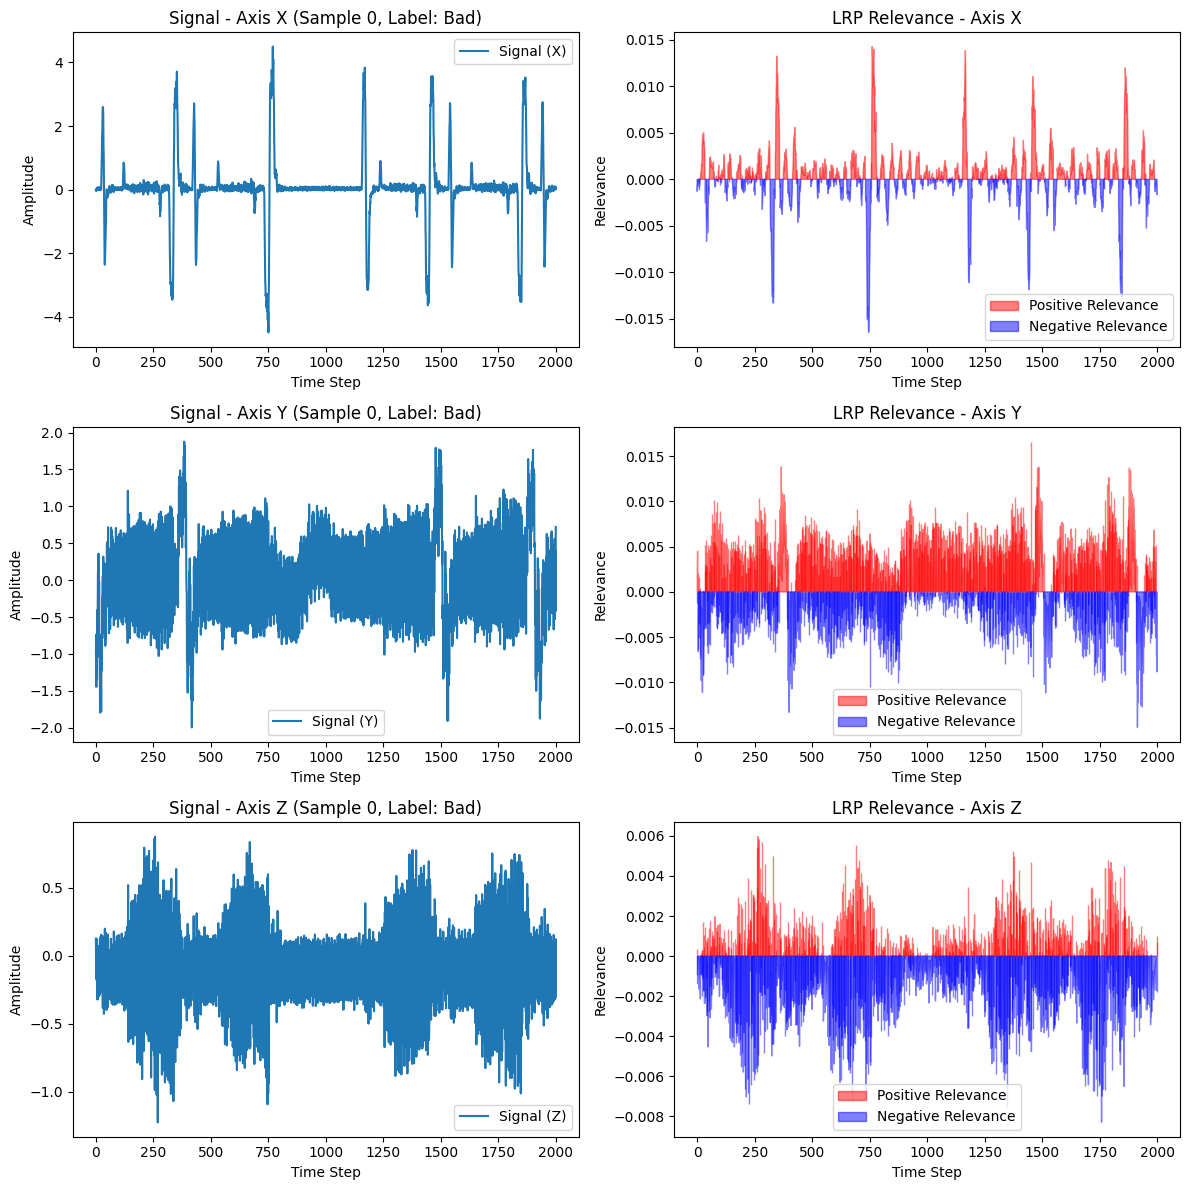

In [62]:
relevance_b, input_signal_b, final_label_b = compute_lrp_relevance(
    model=freq_model,
    sample=sample_b,  # Shape: (3, 10000) or torch tensor
    label=label_b,  # Use true label or None for prediction
    device=device
)
print(f"Sample {random_index_b} Label: {'Good' if final_label_b == 0 else 'Bad'}")

# Visualize LRP relevances (use your existing `visualize_lrp_relevance_single_sample` function)
visualize_lrp_single_sample(
    signal=input_signal_b,
    relevance=relevance_b,
    label=final_label_b)

Min relevance: -0.01645870879292488, Max relevance: 0.01659443788230419
 Maximum Absolute Attribution in Axis 0: 0.01645870879292488
 Maximum Absolute Attribution in Axis 1: 0.01659443788230419
 Maximum Absolute Attribution in Axis 2: 0.008298205211758614


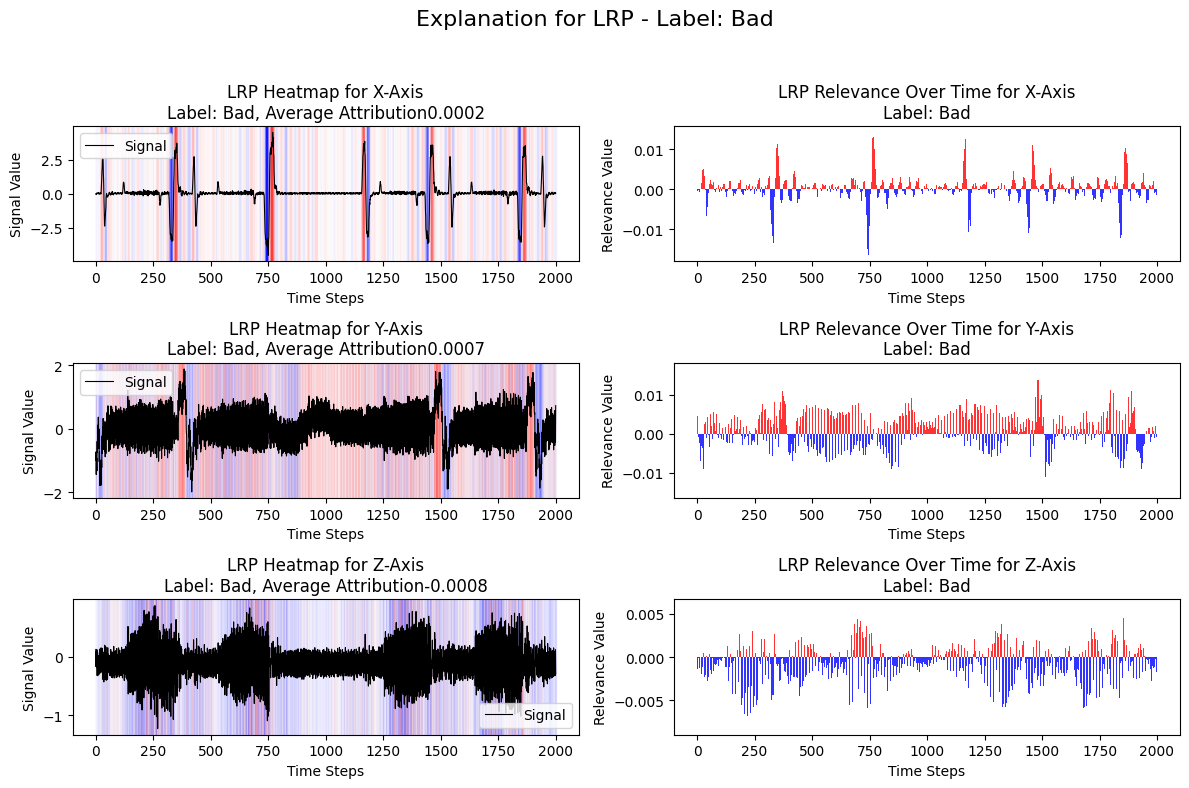

In [63]:

print(f"Min relevance: {np.min(relevance_b)}, Max relevance: {np.max(relevance_b)}")
visualize_with_label_attribution(sample_b, relevance_b, label_b, "LRP")


In [64]:
relevance_time_b, relevance_freq_b, signal_freq_b, input_signal_b, freqs_b, predicted_label_b = compute_dft_lrp_relevance(
        model=freq_model,
        sample=sample_b.cpu().detach().numpy(),  # Convert to NumPy for DFTLRP
        label=label_b.item(),
        device=device,
        signal_length=2000,
        sampling_rate=400  # Placeholder, replace with your actual sampling rate
    )

Input device in zennit_relevance: cuda:0
Input device in zennit_relevance_lrp: cuda:0
Input sample shape: torch.Size([1, 3, 2000])
Relevance time shape: (3, 2000)
Input signal shape: (3, 2000)
Weight shape in create_fourier_weights: (2000, 2000)
Raw weight shape from dft_utils: (2000, 2000)
Weight shape after tensor conversion: torch.Size([2000, 2000])
Weight shape in create_fourier_weights: (2000, 2000)
Raw weight shape from dft_utils: (2000, 2000)
Weight shape after tensor conversion: torch.Size([2000, 2000])
Number of axis is: 3
Frequency length is:1001
Input signal shape: (1, 2000)
Input relevance shape: (1, 2000)
Signal hat shape after transform: torch.Size([1, 2000])
Relevance hat shape before multiplication: torch.Size([1, 2000])
Relevance hat shape after multiplication: torch.Size([1, 2000])
Input signal shape: (1, 2000)
Input relevance shape: (1, 2000)
Signal hat shape after transform: torch.Size([1, 2000])
Relevance hat shape before multiplication: torch.Size([1, 2000])
Relev

E:\Thesis\Datasets\CNC\utils\dft_lrp.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input, dtype=dtype)


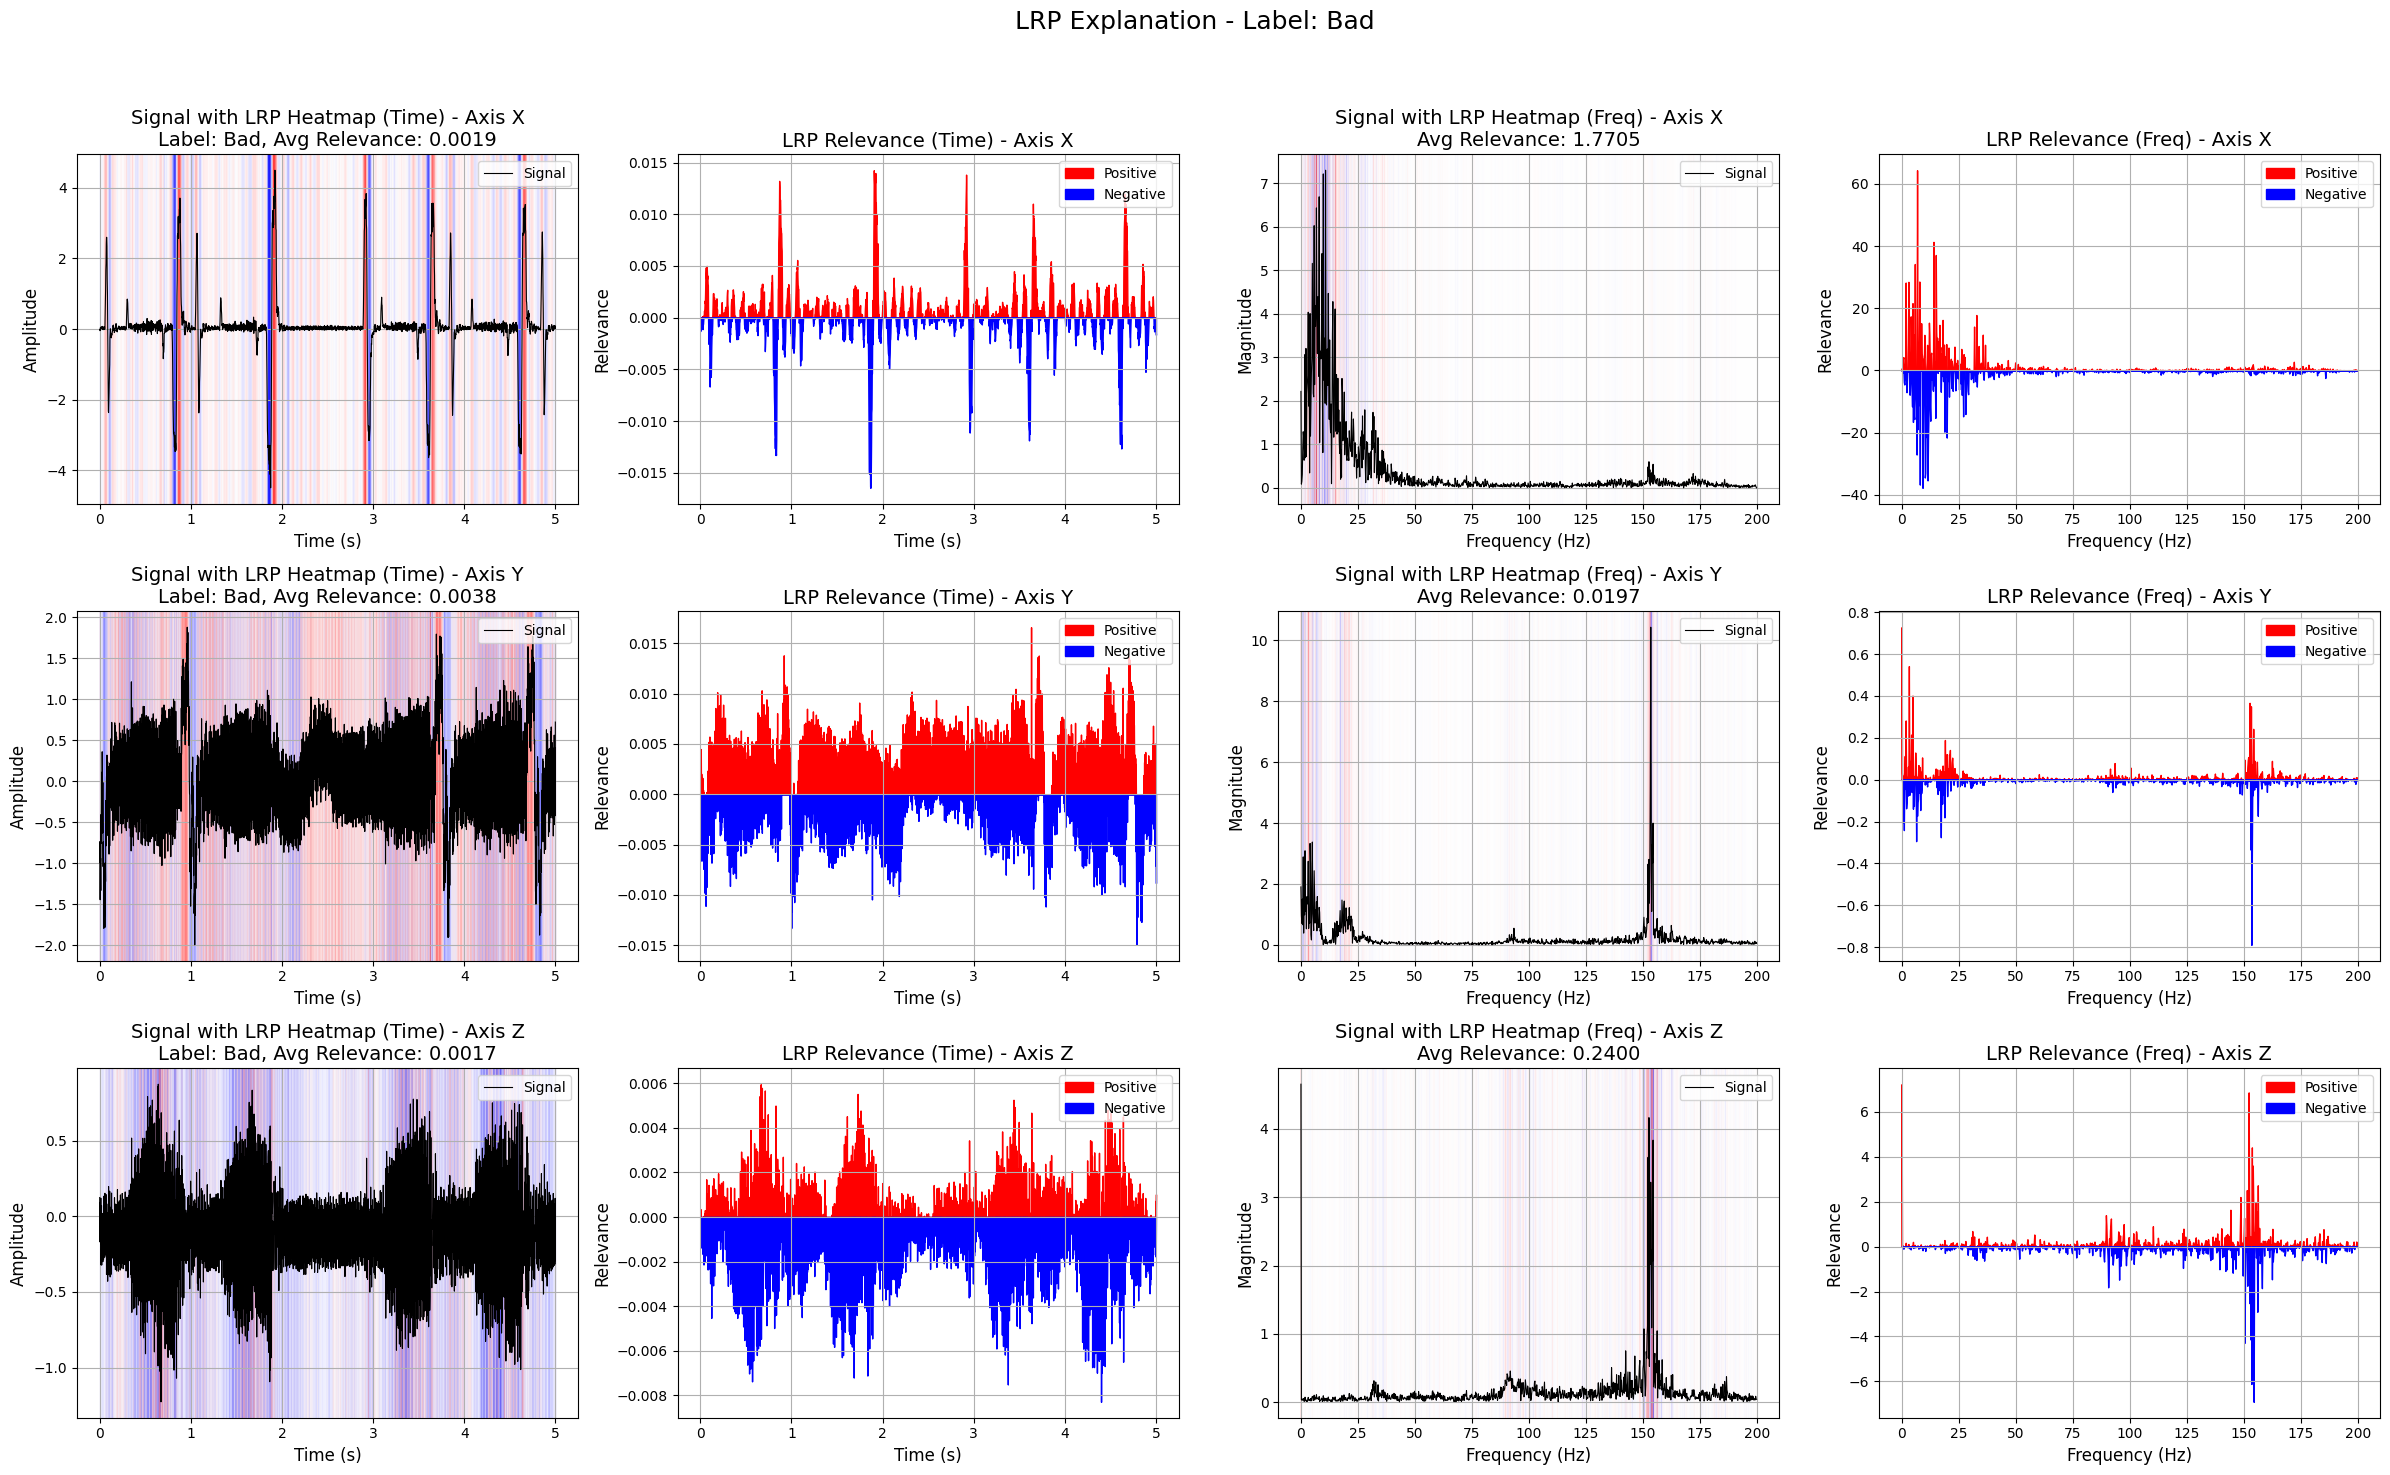

In [65]:
# Visualize the results
visualize_lrp_dft(
        relevance_time=relevance_time_b,
        relevance_freq=relevance_freq_b,
        signal_freq=signal_freq_b,
        input_signal=input_signal_b,
        freqs=freqs_b,
        predicted_label=predicted_label_b,
        k_max=1000,  # Plot up to 1000 Hz
        sampling_rate=400  # Placeholder, replace with your actual sampling rate
    )

In [66]:
summary_b_lrp = summarize_attributions( relevance_freq_b)  # Pass your attributions here

# Flatten the summary dictionary and create a DataFrame
data_lrp = []
for axis, values in summary_b_lrp.items():
    row = {"Axis": axis}
    row.update(values)
    data_lrp.append(row)

# Create the DataFrame
df_summary_lrp = pd.DataFrame(data_lrp)

# Display the DataFrame as a table
print(df_summary_lrp)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0             497                886.104409   
1  Axis 1             495                 10.589162   
2  Axis 2             492                119.347193   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    1.782906             504               -886.189268   
1                    0.021392             506                 -9.176877   
2                    0.242576             509               -120.893840   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -1.758312                    -0.084859   
1                   -0.018136                     1.412284   
2                   -0.237512                    -1.546647   

   Average Relevance (Pos + Neg)  
0                      -0.000085  
1                       0.001411  
2                      -0.001545  


In [67]:
""# Global Attribution over frequency with LRP
summary_lrp_t_b = summarize_attributions(relevance_time_b)  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_lrp_t_b = []
for axis, values in summary_lrp_t_b.items():
    row = {"Axis": axis}
    row.update(values)
    data_lrp_t_b.append(row)

# Create the DataFrame
df_summary_lrp_t_b = pd.DataFrame(data_lrp_t_b)

# Display the DataFrame as a table
print(df_summary_lrp_t_b)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0            1130                  2.119408   
1  Axis 1            1101                  4.451190   
2  Axis 2             683                  0.871640   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.001876             870                 -1.753231   
1                    0.004043             899                 -3.063274   
2                    0.001276            1317                 -2.459712   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.002015                     0.366176   
1                   -0.003407                     1.387917   
2                   -0.001868                    -1.588072   

   Average Relevance (Pos + Neg)  
0                       0.000183  
1                       0.000694  
2                      -0.000794  


In [68]:
relevance_time_fft_b, relevance_freq_fft_b, signal_freq_fft_b, relevance_timefreq_fft_b, signal_timefreq_fft_b, input_signal_fft_b, freqs_fft_b, predicted_label_fft_b = compute_fft_lrp_relevance(
        model=freq_model,
        sample=sample_b,
        label=None,
        signal_length=2000,
        sampling_rate=400,
        compute_timefreq=True,
        window_shift=50,  # Increased to reduce memory usage
        window_width=100,
        window_shape="rectangle"
    )

Input sample shape: torch.Size([1, 3, 2000])
Target label: 1
Input device in zennit_relevance: cuda:0
Input device in zennit_relevance_lrp: cuda:0
relevance_time_tensor shape before squeeze: (1, 3, 2000)
relevance_time shape after squeeze: (3, 2000)
input_signal shape: (3, 2000)
fft_lrp: Input relevance shape = (1, 2000), signal shape = (1, 2000)
fft_lrp: relevance_tensor shape = torch.Size([1, 2000]), signal_tensor shape = torch.Size([1, 2000])
fourier_transform: signal_tensor shape = torch.Size([1, 2000])
fourier_transform (FFT): signal_hat shape = torch.Size([1, 1001])
fft_lrp: signal_hat shape = torch.Size([1, 1001])
fft_lrp: relevance_normed shape = torch.Size([1, 2000])
fft_lrp: relevance_fft real part = tensor([[ 0.2714,  4.3615, -1.9358,  ...,  0.0801,  2.9327, -5.1185]],
       device='cuda:0')
fft_lrp: relevance_fft imag part = tensor([[ 0.0000, -1.3265, -3.1977,  ...,  2.1839, -1.0389,  0.0000]],
       device='cuda:0')
fft_lrp: relevance_hat real part before cpu = tensor([[

In [69]:

# Global Attribution for FFT_LRP over frequency
summary_fft_freq_b = summarize_attributions(relevance_freq_fft_b)  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_fft_freq_b = []
for axis, values in summary_fft_freq_b.items():
    row = {"Axis": axis}
    row.update(values)
    data_fft_freq_b.append(row)

# Create the DataFrame
df_summary_fft_freq_b = pd.DataFrame(data_fft_freq_b)

# Display the DataFrame as a table
print(df_summary_fft_freq_b)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0             498  1171.861145+   0.000000j   
1  Axis 1             494    21.099051+   0.000000j   
2  Axis 2             491   372.623138+   0.000000j   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0          2.353135+0.000000j             503 -1160.694611+   0.000000j   
1          0.042711+0.000000j             507   -21.989407+   0.000000j   
2          0.758907+0.000000j             510  -365.223762+   0.000000j   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0         -2.307544+0.000000j         11.166533+ 0.000000j   
1         -0.043372+0.000000j         -0.890356+ 0.000000j   
2         -0.716125+0.000000j          7.399375+ 0.000000j   

   Average Relevance (Pos + Neg)  
0             0.011155+0.000000j  
1            -0.000889+0.000000j  
2             0.007392+0.000000j  


In [70]:
# Global Attribution for FFT_LRP over time frequency
summary_fft_timefreq_b = summarize_attributions(relevance_timefreq_fft_b)  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_fft_timefreq_b = []
for axis, values in summary_fft_timefreq_b.items():
    row = {"Axis": axis}
    row.update(values)
    data_fft_timefreq_b.append(row)

# Create the DataFrame
df_summary_fft_timefreq_b = pd.DataFrame(data_fft_timefreq_b)

# Display the DataFrame as a table
print(df_summary_fft_timefreq_b)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0           10132  4190.404640+   0.000000j   
1  Axis 1            9923    57.541811+   0.000000j   
2  Axis 2            9619  1562.063415+   0.000000j   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0          0.413581+0.000000j            9887 -4109.117949+   0.000000j   
1          0.005799+0.000000j           10097   -52.709239+   0.000000j   
2          0.162394+0.000000j           10401 -1660.698019+   0.000000j   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0         -0.415608+0.000000j         81.286691+ 0.000000j   
1         -0.005220+0.000000j          4.832572+ 0.000000j   
2         -0.159667+0.000000j        -98.634604+ 0.000000j   

   Average Relevance (Pos + Neg)  
0             0.004060+0.000000j  
1             0.000241+0.000000j  
2            -0.004927+0.000000j  


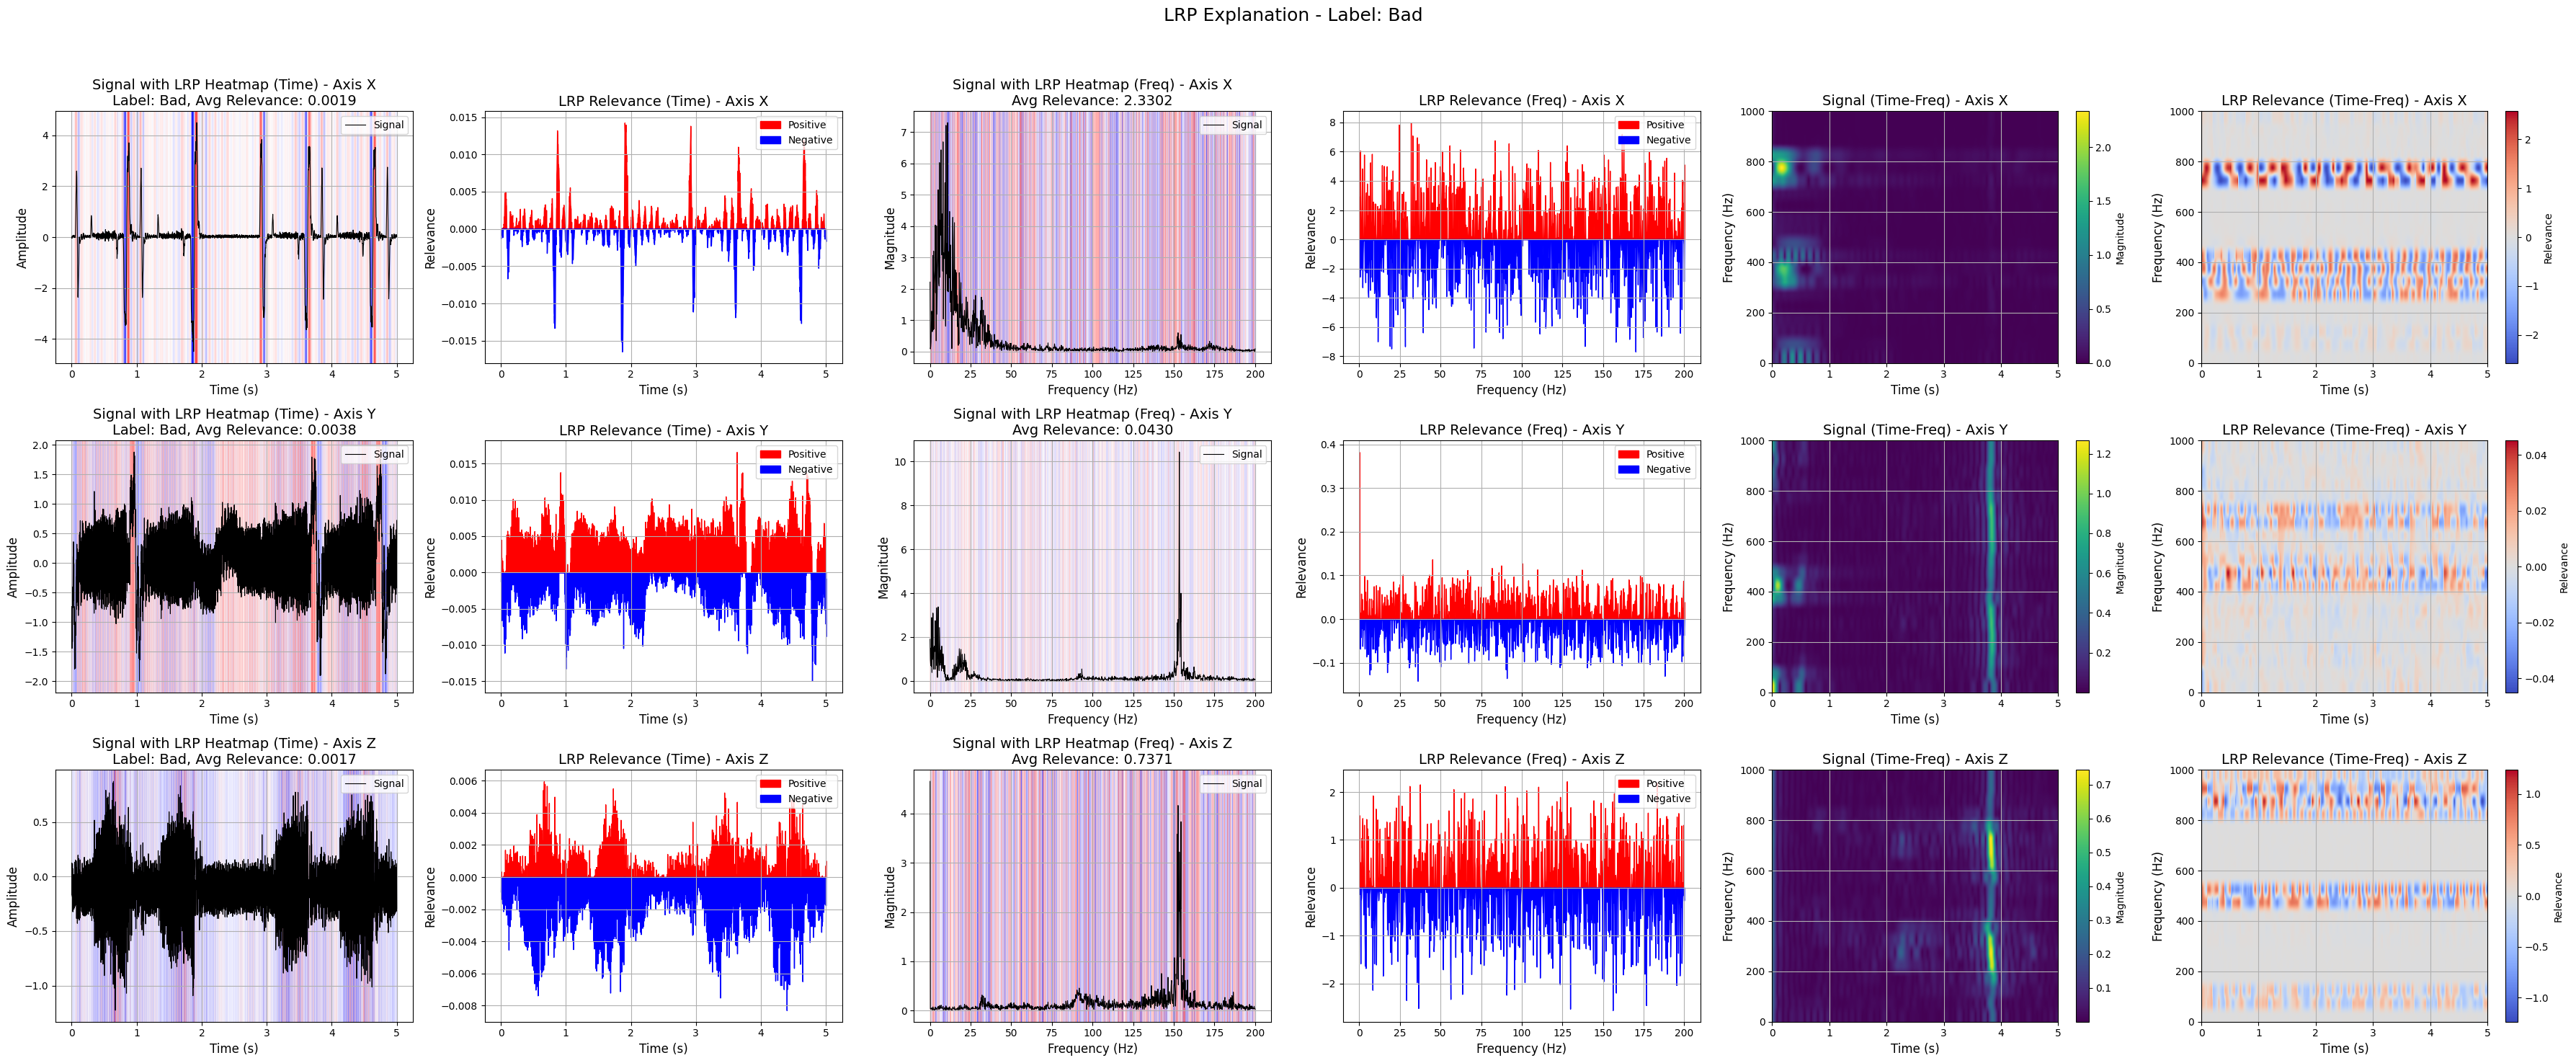

In [71]:
# Visualize
visualize_lrp_fft(
    relevance_time=relevance_time_fft_b,
    relevance_freq=relevance_freq_fft_b,
    signal_freq=signal_freq_fft_b,
    relevance_timefreq=relevance_timefreq_fft_b,
    signal_timefreq=signal_timefreq_fft_b,
    input_signal=input_signal_fft_b,
    freqs=freqs_fft_b,
    predicted_label=predicted_label_fft_b,
    signal_length=2000,
    sampling_rate=400,
    k_max=1000
)